In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 zrgay7lq


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-zrgay7lq:best, 58.49MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:1.9


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                      | 0/5208 [00:00<?, ?it/s]

  0%|                                                                                                              | 1/5208 [00:00<50:48,  1.71it/s]

  0%|▏                                                                                                             | 7/5208 [00:00<06:44, 12.86it/s]

  0%|▎                                                                                                            | 13/5208 [00:00<03:54, 22.13it/s]

  0%|▍                                                                                                            | 19/5208 [00:00<02:52, 30.02it/s]

  0%|▌                                                                                                            | 25/5208 [00:01<02:25, 35.70it/s]

  1%|▋                                                                                                            | 31/5208 [00:01<02:07, 40.58it/s]

  1%|▊                                                                                                            | 37/5208 [00:01<01:58, 43.55it/s]

  1%|▉                                                                                                            | 43/5208 [00:01<01:51, 46.31it/s]

  1%|█                                                                                                            | 49/5208 [00:01<01:47, 47.78it/s]

  1%|█▏                                                                                                           | 55/5208 [00:01<01:45, 48.65it/s]

  1%|█▎                                                                                                           | 61/5208 [00:01<01:42, 50.10it/s]

  1%|█▍                                                                                                           | 67/5208 [00:01<01:42, 50.28it/s]

  1%|█▌                                                                                                           | 73/5208 [00:01<01:39, 51.36it/s]

  2%|█▋                                                                                                           | 79/5208 [00:02<01:40, 51.13it/s]

  2%|█▊                                                                                                           | 85/5208 [00:02<01:38, 52.00it/s]

  2%|█▉                                                                                                           | 91/5208 [00:02<01:39, 51.59it/s]

  2%|██                                                                                                           | 97/5208 [00:02<01:37, 52.25it/s]

  2%|██▏                                                                                                         | 103/5208 [00:02<01:38, 51.81it/s]

  2%|██▎                                                                                                         | 109/5208 [00:02<01:37, 52.41it/s]

  2%|██▍                                                                                                         | 115/5208 [00:02<01:38, 51.94it/s]

  2%|██▌                                                                                                         | 121/5208 [00:02<01:37, 52.39it/s]

  2%|██▋                                                                                                         | 127/5208 [00:02<01:37, 52.07it/s]

  3%|██▊                                                                                                         | 133/5208 [00:03<01:38, 51.67it/s]

  3%|██▉                                                                                                         | 139/5208 [00:03<01:37, 52.10it/s]

  3%|███                                                                                                         | 145/5208 [00:03<01:37, 51.67it/s]

  3%|███▏                                                                                                        | 151/5208 [00:03<01:36, 52.32it/s]

  3%|███▎                                                                                                        | 157/5208 [00:03<01:37, 51.85it/s]

  3%|███▍                                                                                                        | 163/5208 [00:03<01:36, 52.54it/s]

  3%|███▌                                                                                                        | 169/5208 [00:03<01:36, 51.99it/s]

  3%|███▋                                                                                                        | 175/5208 [00:03<01:35, 52.56it/s]

  3%|███▊                                                                                                        | 181/5208 [00:04<01:36, 52.02it/s]

  4%|███▉                                                                                                        | 187/5208 [00:04<01:35, 52.56it/s]

  4%|████                                                                                                        | 193/5208 [00:04<01:36, 51.97it/s]

  4%|████▏                                                                                                       | 199/5208 [00:04<01:35, 52.32it/s]

  4%|████▎                                                                                                       | 205/5208 [00:04<01:36, 51.94it/s]

  4%|████▍                                                                                                       | 211/5208 [00:04<01:37, 51.50it/s]

  4%|████▌                                                                                                       | 217/5208 [00:04<01:35, 52.10it/s]

  4%|████▌                                                                                                       | 223/5208 [00:04<01:36, 51.69it/s]

  4%|████▋                                                                                                       | 229/5208 [00:04<01:35, 52.35it/s]

  5%|████▊                                                                                                       | 235/5208 [00:05<01:35, 51.86it/s]

  5%|████▉                                                                                                       | 241/5208 [00:05<01:34, 52.49it/s]

  5%|█████                                                                                                       | 247/5208 [00:05<01:35, 51.98it/s]

  5%|█████▏                                                                                                      | 253/5208 [00:05<01:34, 52.59it/s]

  5%|█████▎                                                                                                      | 259/5208 [00:05<01:35, 52.04it/s]

  5%|█████▍                                                                                                      | 265/5208 [00:05<01:33, 52.61it/s]

  5%|█████▌                                                                                                      | 271/5208 [00:05<01:34, 52.09it/s]

  5%|█████▋                                                                                                      | 277/5208 [00:05<01:33, 52.49it/s]

  5%|█████▊                                                                                                      | 283/5208 [00:05<01:34, 52.12it/s]

  6%|█████▉                                                                                                      | 289/5208 [00:06<01:35, 51.72it/s]

  6%|██████                                                                                                      | 295/5208 [00:06<01:34, 52.26it/s]

  6%|██████▏                                                                                                     | 301/5208 [00:06<01:34, 51.82it/s]

  6%|██████▎                                                                                                     | 307/5208 [00:06<01:33, 52.48it/s]

  6%|██████▍                                                                                                     | 313/5208 [00:06<01:34, 51.96it/s]

  6%|██████▌                                                                                                     | 319/5208 [00:06<01:32, 52.59it/s]

  6%|██████▋                                                                                                     | 325/5208 [00:06<01:33, 52.03it/s]

  6%|██████▊                                                                                                     | 331/5208 [00:06<01:32, 52.58it/s]

  6%|██████▉                                                                                                     | 337/5208 [00:07<01:33, 52.04it/s]

  7%|███████                                                                                                     | 343/5208 [00:07<01:32, 52.54it/s]

  7%|███████▏                                                                                                    | 349/5208 [00:07<01:33, 51.93it/s]

  7%|███████▎                                                                                                    | 355/5208 [00:07<01:32, 52.37it/s]

  7%|███████▍                                                                                                    | 361/5208 [00:07<01:33, 52.05it/s]

  7%|███████▌                                                                                                    | 367/5208 [00:07<01:33, 51.68it/s]

  7%|███████▋                                                                                                    | 373/5208 [00:07<01:32, 52.23it/s]

  7%|███████▊                                                                                                    | 379/5208 [00:07<01:33, 51.79it/s]

  7%|███████▉                                                                                                    | 385/5208 [00:07<01:32, 52.40it/s]

  8%|████████                                                                                                    | 391/5208 [00:08<01:32, 51.86it/s]

  8%|████████▏                                                                                                   | 397/5208 [00:08<01:31, 52.44it/s]

  8%|████████▎                                                                                                   | 403/5208 [00:08<01:32, 51.90it/s]

  8%|████████▍                                                                                                   | 409/5208 [00:08<01:31, 52.46it/s]

  8%|████████▌                                                                                                   | 415/5208 [00:08<01:30, 52.99it/s]

  8%|████████▋                                                                                                   | 421/5208 [00:08<01:30, 53.13it/s]

  8%|████████▊                                                                                                   | 427/5208 [00:08<01:30, 52.56it/s]

  8%|████████▉                                                                                                   | 433/5208 [00:08<01:31, 51.99it/s]

  8%|█████████                                                                                                   | 439/5208 [00:08<01:30, 52.43it/s]

  9%|█████████▏                                                                                                  | 445/5208 [00:09<01:31, 51.89it/s]

  9%|█████████▎                                                                                                  | 451/5208 [00:09<01:30, 52.43it/s]

  9%|█████████▍                                                                                                  | 457/5208 [00:09<01:31, 51.84it/s]

  9%|█████████▌                                                                                                  | 463/5208 [00:09<01:30, 52.43it/s]

  9%|█████████▋                                                                                                  | 469/5208 [00:09<01:31, 51.91it/s]

  9%|█████████▊                                                                                                  | 475/5208 [00:09<01:30, 52.48it/s]

  9%|█████████▉                                                                                                  | 481/5208 [00:09<01:30, 51.99it/s]

  9%|██████████                                                                                                  | 487/5208 [00:09<01:29, 52.52it/s]

  9%|██████████▏                                                                                                 | 493/5208 [00:10<01:30, 52.01it/s]

 10%|██████████▎                                                                                                 | 499/5208 [00:10<01:29, 52.41it/s]

 10%|██████████▍                                                                                                 | 505/5208 [00:10<01:30, 52.06it/s]

 10%|██████████▌                                                                                                 | 511/5208 [00:10<01:30, 51.67it/s]

 10%|██████████▋                                                                                                 | 517/5208 [00:10<01:29, 52.20it/s]

 10%|██████████▊                                                                                                 | 523/5208 [00:10<01:30, 51.75it/s]

 10%|██████████▉                                                                                                 | 529/5208 [00:10<01:29, 52.39it/s]

 10%|███████████                                                                                                 | 535/5208 [00:10<01:30, 51.92it/s]

 10%|███████████▏                                                                                                | 541/5208 [00:10<01:28, 52.54it/s]

 11%|███████████▎                                                                                                | 547/5208 [00:11<01:29, 51.99it/s]

 11%|███████████▍                                                                                                | 553/5208 [00:11<01:28, 52.51it/s]

 11%|███████████▌                                                                                                | 559/5208 [00:11<01:29, 51.93it/s]

 11%|███████████▋                                                                                                | 565/5208 [00:11<01:28, 52.48it/s]

 11%|███████████▊                                                                                                | 571/5208 [00:11<01:29, 51.99it/s]

 11%|███████████▉                                                                                                | 577/5208 [00:11<01:28, 52.57it/s]

 11%|████████████                                                                                                | 583/5208 [00:11<01:28, 52.07it/s]

 11%|████████████▏                                                                                               | 589/5208 [00:11<01:29, 51.68it/s]

 11%|████████████▎                                                                                               | 595/5208 [00:11<01:28, 52.23it/s]

 12%|████████████▍                                                                                               | 601/5208 [00:12<01:28, 51.80it/s]

 12%|████████████▌                                                                                               | 607/5208 [00:12<01:27, 52.41it/s]

 12%|████████████▋                                                                                               | 613/5208 [00:12<01:28, 51.89it/s]

 12%|████████████▊                                                                                               | 619/5208 [00:12<01:27, 52.47it/s]

 12%|████████████▉                                                                                               | 625/5208 [00:12<01:28, 51.91it/s]

 12%|█████████████                                                                                               | 631/5208 [00:12<01:27, 52.50it/s]

 12%|█████████████▏                                                                                              | 637/5208 [00:12<01:27, 51.98it/s]

 12%|█████████████▎                                                                                              | 643/5208 [00:12<01:26, 52.53it/s]

 12%|█████████████▍                                                                                              | 649/5208 [00:13<01:27, 51.99it/s]

 13%|█████████████▌                                                                                              | 655/5208 [00:13<01:26, 52.40it/s]

 13%|█████████████▋                                                                                              | 661/5208 [00:13<01:27, 52.04it/s]

 13%|█████████████▊                                                                                              | 667/5208 [00:13<01:27, 51.66it/s]

 13%|█████████████▉                                                                                              | 673/5208 [00:13<01:26, 52.23it/s]

 13%|██████████████                                                                                              | 679/5208 [00:13<01:27, 51.77it/s]

 13%|██████████████▏                                                                                             | 685/5208 [00:13<01:26, 52.37it/s]

 13%|██████████████▎                                                                                             | 691/5208 [00:13<01:27, 51.85it/s]

 13%|██████████████▍                                                                                             | 697/5208 [00:13<01:25, 52.48it/s]

 13%|██████████████▌                                                                                             | 703/5208 [00:14<01:26, 51.96it/s]

 14%|██████████████▋                                                                                             | 709/5208 [00:14<01:25, 52.53it/s]

 14%|██████████████▊                                                                                             | 715/5208 [00:14<01:26, 51.98it/s]

 14%|██████████████▉                                                                                             | 721/5208 [00:14<01:25, 52.48it/s]

 14%|███████████████                                                                                             | 727/5208 [00:14<01:26, 51.92it/s]

 14%|███████████████▏                                                                                            | 733/5208 [00:14<01:25, 52.35it/s]

 14%|███████████████▎                                                                                            | 739/5208 [00:14<01:25, 52.03it/s]

 14%|███████████████▍                                                                                            | 745/5208 [00:14<01:26, 51.64it/s]

 14%|███████████████▌                                                                                            | 751/5208 [00:14<01:25, 52.20it/s]

 15%|███████████████▋                                                                                            | 757/5208 [00:15<01:26, 51.75it/s]

 15%|███████████████▊                                                                                            | 763/5208 [00:15<01:24, 52.35it/s]

 15%|███████████████▉                                                                                            | 769/5208 [00:15<01:25, 51.87it/s]

 15%|████████████████                                                                                            | 775/5208 [00:15<01:24, 52.49it/s]

 15%|████████████████▏                                                                                           | 781/5208 [00:15<01:25, 51.95it/s]

 15%|████████████████▎                                                                                           | 787/5208 [00:15<01:24, 52.50it/s]

 15%|████████████████▍                                                                                           | 793/5208 [00:15<01:24, 51.99it/s]

 15%|████████████████▌                                                                                           | 799/5208 [00:15<01:23, 52.52it/s]

 15%|████████████████▋                                                                                           | 805/5208 [00:15<01:24, 52.00it/s]

 16%|████████████████▊                                                                                           | 811/5208 [00:16<01:23, 52.40it/s]

 16%|████████████████▉                                                                                           | 817/5208 [00:16<01:24, 52.06it/s]

 16%|█████████████████                                                                                           | 823/5208 [00:16<01:24, 51.60it/s]

 16%|█████████████████▏                                                                                          | 829/5208 [00:16<01:23, 52.21it/s]

 16%|█████████████████▎                                                                                          | 835/5208 [00:16<01:24, 51.74it/s]

 16%|█████████████████▍                                                                                          | 841/5208 [00:16<01:23, 52.37it/s]

 16%|█████████████████▌                                                                                          | 847/5208 [00:16<01:24, 51.87it/s]

 16%|█████████████████▋                                                                                          | 853/5208 [00:16<01:22, 52.54it/s]

 16%|█████████████████▊                                                                                          | 859/5208 [00:17<01:23, 52.00it/s]

 17%|█████████████████▉                                                                                          | 865/5208 [00:17<01:22, 52.53it/s]

 17%|██████████████████                                                                                          | 871/5208 [00:17<01:23, 51.99it/s]

 17%|██████████████████▏                                                                                         | 877/5208 [00:17<01:22, 52.52it/s]

 17%|██████████████████▎                                                                                         | 883/5208 [00:17<01:23, 52.02it/s]

 17%|██████████████████▍                                                                                         | 889/5208 [00:17<01:22, 52.40it/s]

 17%|██████████████████▌                                                                                         | 895/5208 [00:17<01:22, 52.05it/s]

 17%|██████████████████▋                                                                                         | 901/5208 [00:17<01:23, 51.68it/s]

 17%|██████████████████▊                                                                                         | 907/5208 [00:17<01:22, 52.26it/s]

 18%|██████████████████▉                                                                                         | 913/5208 [00:18<01:22, 51.80it/s]

 18%|███████████████████                                                                                         | 919/5208 [00:18<01:21, 52.38it/s]

 18%|███████████████████▏                                                                                        | 925/5208 [00:18<01:22, 51.87it/s]

 18%|███████████████████▎                                                                                        | 931/5208 [00:18<01:21, 52.47it/s]

 18%|███████████████████▍                                                                                        | 937/5208 [00:18<01:22, 51.91it/s]

 18%|███████████████████▌                                                                                        | 943/5208 [00:18<01:21, 52.44it/s]

 18%|███████████████████▋                                                                                        | 949/5208 [00:18<01:22, 51.93it/s]

 18%|███████████████████▊                                                                                        | 955/5208 [00:18<01:21, 52.46it/s]

 18%|███████████████████▉                                                                                        | 961/5208 [00:18<01:21, 51.98it/s]

 19%|████████████████████                                                                                        | 967/5208 [00:19<01:20, 52.39it/s]

 19%|████████████████████▏                                                                                       | 973/5208 [00:19<01:21, 52.01it/s]

 19%|████████████████████▎                                                                                       | 979/5208 [00:19<01:21, 51.62it/s]

 19%|████████████████████▍                                                                                       | 985/5208 [00:19<01:20, 52.15it/s]

 19%|████████████████████▌                                                                                       | 991/5208 [00:19<01:21, 51.73it/s]

 19%|████████████████████▋                                                                                       | 997/5208 [00:19<01:20, 52.32it/s]

 19%|████████████████████▌                                                                                      | 1003/5208 [00:19<01:21, 51.85it/s]

 19%|████████████████████▋                                                                                      | 1009/5208 [00:19<01:20, 52.44it/s]

 19%|████████████████████▊                                                                                      | 1015/5208 [00:20<01:20, 51.93it/s]

 20%|████████████████████▉                                                                                      | 1021/5208 [00:20<01:19, 52.46it/s]

 20%|█████████████████████                                                                                      | 1027/5208 [00:20<01:20, 51.99it/s]

 20%|█████████████████████▏                                                                                     | 1033/5208 [00:20<01:19, 52.50it/s]

 20%|█████████████████████▎                                                                                     | 1039/5208 [00:20<01:20, 52.01it/s]

 20%|█████████████████████▍                                                                                     | 1045/5208 [00:20<01:19, 52.43it/s]

 20%|█████████████████████▌                                                                                     | 1051/5208 [00:20<01:19, 52.06it/s]

 20%|█████████████████████▋                                                                                     | 1057/5208 [00:20<01:20, 51.67it/s]

 20%|█████████████████████▊                                                                                     | 1063/5208 [00:20<01:19, 52.22it/s]

 21%|█████████████████████▉                                                                                     | 1069/5208 [00:21<01:19, 51.76it/s]

 21%|██████████████████████                                                                                     | 1075/5208 [00:21<01:18, 52.32it/s]

 21%|██████████████████████▏                                                                                    | 1081/5208 [00:21<01:19, 51.86it/s]

 21%|██████████████████████▎                                                                                    | 1087/5208 [00:21<01:18, 52.51it/s]

 21%|██████████████████████▍                                                                                    | 1093/5208 [00:21<01:19, 51.96it/s]

 21%|██████████████████████▌                                                                                    | 1099/5208 [00:21<01:18, 52.51it/s]

 21%|██████████████████████▋                                                                                    | 1105/5208 [00:21<01:18, 52.01it/s]

 21%|██████████████████████▊                                                                                    | 1111/5208 [00:21<01:17, 52.53it/s]

 21%|██████████████████████▉                                                                                    | 1117/5208 [00:21<01:18, 52.01it/s]

 22%|███████████████████████                                                                                    | 1123/5208 [00:22<01:18, 52.37it/s]

 22%|███████████████████████▏                                                                                   | 1129/5208 [00:22<01:18, 52.07it/s]

 22%|███████████████████████▎                                                                                   | 1135/5208 [00:22<01:18, 51.68it/s]

 22%|███████████████████████▍                                                                                   | 1141/5208 [00:22<01:17, 52.21it/s]

 22%|███████████████████████▌                                                                                   | 1147/5208 [00:22<01:18, 51.78it/s]

 22%|███████████████████████▋                                                                                   | 1153/5208 [00:22<01:17, 52.40it/s]

 22%|███████████████████████▊                                                                                   | 1159/5208 [00:22<01:18, 51.90it/s]

 22%|███████████████████████▉                                                                                   | 1165/5208 [00:22<01:16, 52.52it/s]

 22%|████████████████████████                                                                                   | 1171/5208 [00:23<01:17, 51.99it/s]

 23%|████████████████████████▏                                                                                  | 1177/5208 [00:23<01:16, 52.52it/s]

 23%|████████████████████████▎                                                                                  | 1183/5208 [00:23<01:17, 51.97it/s]

 23%|████████████████████████▍                                                                                  | 1189/5208 [00:23<01:16, 52.51it/s]

 23%|████████████████████████▌                                                                                  | 1195/5208 [00:23<01:17, 52.00it/s]

 23%|████████████████████████▋                                                                                  | 1201/5208 [00:23<01:16, 52.39it/s]

 23%|████████████████████████▊                                                                                  | 1207/5208 [00:23<01:16, 52.08it/s]

 23%|████████████████████████▉                                                                                  | 1213/5208 [00:23<01:17, 51.67it/s]

 23%|█████████████████████████                                                                                  | 1219/5208 [00:23<01:16, 52.24it/s]

 24%|█████████████████████████▏                                                                                 | 1225/5208 [00:24<01:16, 51.83it/s]

 24%|█████████████████████████▎                                                                                 | 1231/5208 [00:24<01:15, 52.44it/s]

 24%|█████████████████████████▍                                                                                 | 1237/5208 [00:24<01:16, 51.91it/s]

 24%|█████████████████████████▌                                                                                 | 1243/5208 [00:24<01:15, 52.52it/s]

 24%|█████████████████████████▋                                                                                 | 1249/5208 [00:24<01:16, 52.01it/s]

 24%|█████████████████████████▊                                                                                 | 1255/5208 [00:24<01:15, 52.55it/s]

 24%|█████████████████████████▉                                                                                 | 1261/5208 [00:24<01:15, 52.02it/s]

 24%|██████████████████████████                                                                                 | 1267/5208 [00:24<01:14, 52.55it/s]

 24%|██████████████████████████▏                                                                                | 1273/5208 [00:24<01:15, 52.03it/s]

 25%|██████████████████████████▎                                                                                | 1279/5208 [00:25<01:14, 52.43it/s]

 25%|██████████████████████████▍                                                                                | 1285/5208 [00:25<01:15, 52.11it/s]

 25%|██████████████████████████▌                                                                                | 1291/5208 [00:25<01:15, 51.68it/s]

 25%|██████████████████████████▋                                                                                | 1297/5208 [00:25<01:14, 52.22it/s]

 25%|██████████████████████████▊                                                                                | 1303/5208 [00:25<01:15, 51.79it/s]

 25%|██████████████████████████▉                                                                                | 1309/5208 [00:25<01:14, 52.39it/s]

 25%|███████████████████████████                                                                                | 1315/5208 [00:25<01:14, 51.92it/s]

 25%|███████████████████████████▏                                                                               | 1321/5208 [00:25<01:14, 52.53it/s]

 25%|███████████████████████████▎                                                                               | 1327/5208 [00:26<01:14, 51.98it/s]

 26%|███████████████████████████▍                                                                               | 1333/5208 [00:26<01:13, 52.52it/s]

 26%|███████████████████████████▌                                                                               | 1339/5208 [00:26<01:14, 52.01it/s]

 26%|███████████████████████████▋                                                                               | 1345/5208 [00:26<01:13, 52.53it/s]

 26%|███████████████████████████▊                                                                               | 1351/5208 [00:26<01:14, 52.02it/s]

 26%|███████████████████████████▉                                                                               | 1357/5208 [00:26<01:13, 52.41it/s]

 26%|████████████████████████████                                                                               | 1363/5208 [00:26<01:13, 52.08it/s]

 26%|████████████████████████████▏                                                                              | 1369/5208 [00:26<01:14, 51.70it/s]

 26%|████████████████████████████▏                                                                              | 1375/5208 [00:26<01:13, 52.25it/s]

 27%|████████████████████████████▎                                                                              | 1381/5208 [00:27<01:13, 51.81it/s]

 27%|████████████████████████████▍                                                                              | 1387/5208 [00:27<01:12, 52.41it/s]

 27%|████████████████████████████▌                                                                              | 1393/5208 [00:27<01:13, 51.90it/s]

 27%|████████████████████████████▋                                                                              | 1399/5208 [00:27<01:12, 52.53it/s]

 27%|████████████████████████████▊                                                                              | 1405/5208 [00:27<01:13, 52.01it/s]

 27%|████████████████████████████▉                                                                              | 1411/5208 [00:27<01:12, 52.55it/s]

 27%|█████████████████████████████                                                                              | 1417/5208 [00:27<01:12, 52.02it/s]

 27%|█████████████████████████████▏                                                                             | 1423/5208 [00:27<01:12, 52.56it/s]

 27%|█████████████████████████████▎                                                                             | 1429/5208 [00:27<01:12, 52.04it/s]

 28%|█████████████████████████████▍                                                                             | 1435/5208 [00:28<01:11, 52.44it/s]

 28%|█████████████████████████████▌                                                                             | 1441/5208 [00:28<01:12, 52.11it/s]

 28%|█████████████████████████████▋                                                                             | 1447/5208 [00:28<01:12, 51.75it/s]

 28%|█████████████████████████████▊                                                                             | 1453/5208 [00:28<01:11, 52.30it/s]

 28%|█████████████████████████████▉                                                                             | 1459/5208 [00:28<01:12, 51.82it/s]

 28%|██████████████████████████████                                                                             | 1465/5208 [00:28<01:11, 52.39it/s]

 28%|██████████████████████████████▏                                                                            | 1471/5208 [00:28<01:12, 51.89it/s]

 28%|██████████████████████████████▎                                                                            | 1477/5208 [00:28<01:11, 52.51it/s]

 28%|██████████████████████████████▍                                                                            | 1483/5208 [00:29<01:11, 51.97it/s]

 29%|██████████████████████████████▌                                                                            | 1489/5208 [00:29<01:10, 52.53it/s]

 29%|██████████████████████████████▋                                                                            | 1495/5208 [00:29<01:11, 51.98it/s]

 29%|██████████████████████████████▊                                                                            | 1501/5208 [00:29<01:10, 52.50it/s]

 29%|██████████████████████████████▉                                                                            | 1507/5208 [00:29<01:11, 52.00it/s]

 29%|███████████████████████████████                                                                            | 1513/5208 [00:29<01:10, 52.40it/s]

 29%|███████████████████████████████▏                                                                           | 1519/5208 [00:29<01:10, 52.07it/s]

 29%|███████████████████████████████▎                                                                           | 1525/5208 [00:29<01:11, 51.66it/s]

 29%|███████████████████████████████▍                                                                           | 1531/5208 [00:29<01:10, 52.20it/s]

 30%|███████████████████████████████▌                                                                           | 1537/5208 [00:30<01:10, 51.79it/s]

 30%|███████████████████████████████▋                                                                           | 1543/5208 [00:30<01:10, 52.36it/s]

 30%|███████████████████████████████▊                                                                           | 1549/5208 [00:30<01:10, 51.88it/s]

 30%|███████████████████████████████▉                                                                           | 1555/5208 [00:30<01:09, 52.48it/s]

 30%|████████████████████████████████                                                                           | 1561/5208 [00:30<01:10, 51.97it/s]

 30%|████████████████████████████████▏                                                                          | 1567/5208 [00:30<01:09, 52.51it/s]

 30%|████████████████████████████████▎                                                                          | 1573/5208 [00:30<01:09, 52.00it/s]

 30%|████████████████████████████████▍                                                                          | 1579/5208 [00:30<01:09, 52.51it/s]

 30%|████████████████████████████████▌                                                                          | 1585/5208 [00:30<01:09, 52.01it/s]

 31%|████████████████████████████████▋                                                                          | 1591/5208 [00:31<01:08, 52.43it/s]

 31%|████████████████████████████████▊                                                                          | 1597/5208 [00:31<01:09, 52.08it/s]

 31%|████████████████████████████████▉                                                                          | 1603/5208 [00:31<01:09, 51.67it/s]

 31%|█████████████████████████████████                                                                          | 1609/5208 [00:31<01:08, 52.24it/s]

 31%|█████████████████████████████████▏                                                                         | 1615/5208 [00:31<01:09, 51.80it/s]

 31%|█████████████████████████████████▎                                                                         | 1621/5208 [00:31<01:08, 52.40it/s]

 31%|█████████████████████████████████▍                                                                         | 1627/5208 [00:31<01:09, 51.88it/s]

 31%|█████████████████████████████████▌                                                                         | 1633/5208 [00:31<01:08, 52.50it/s]

 31%|█████████████████████████████████▋                                                                         | 1639/5208 [00:31<01:08, 51.95it/s]

 32%|█████████████████████████████████▊                                                                         | 1645/5208 [00:32<01:07, 52.53it/s]

 32%|█████████████████████████████████▉                                                                         | 1651/5208 [00:32<01:08, 52.04it/s]

 32%|██████████████████████████████████                                                                         | 1657/5208 [00:32<01:07, 52.58it/s]

 32%|██████████████████████████████████▏                                                                        | 1663/5208 [00:32<01:08, 51.98it/s]

 32%|██████████████████████████████████▎                                                                        | 1669/5208 [00:32<01:07, 52.42it/s]

 32%|██████████████████████████████████▍                                                                        | 1675/5208 [00:32<01:07, 52.06it/s]

 32%|██████████████████████████████████▌                                                                        | 1681/5208 [00:32<01:08, 51.66it/s]

 32%|██████████████████████████████████▋                                                                        | 1687/5208 [00:32<01:07, 52.18it/s]

 33%|██████████████████████████████████▊                                                                        | 1693/5208 [00:33<01:07, 51.71it/s]

 33%|██████████████████████████████████▉                                                                        | 1699/5208 [00:33<01:07, 52.32it/s]

 33%|███████████████████████████████████                                                                        | 1705/5208 [00:33<01:07, 51.80it/s]

 33%|███████████████████████████████████▏                                                                       | 1711/5208 [00:33<01:06, 52.38it/s]

 33%|███████████████████████████████████▎                                                                       | 1717/5208 [00:33<01:07, 51.85it/s]

 33%|███████████████████████████████████▍                                                                       | 1723/5208 [00:33<01:06, 52.44it/s]

 33%|███████████████████████████████████▌                                                                       | 1729/5208 [00:33<01:06, 51.95it/s]

 33%|███████████████████████████████████▋                                                                       | 1735/5208 [00:33<01:06, 52.48it/s]

 33%|███████████████████████████████████▊                                                                       | 1741/5208 [00:33<01:06, 51.99it/s]

 34%|███████████████████████████████████▉                                                                       | 1747/5208 [00:34<01:06, 52.40it/s]

 34%|████████████████████████████████████                                                                       | 1753/5208 [00:34<01:06, 52.09it/s]

 34%|████████████████████████████████████▏                                                                      | 1759/5208 [00:34<01:06, 51.70it/s]

 34%|████████████████████████████████████▎                                                                      | 1765/5208 [00:34<01:05, 52.27it/s]

 34%|████████████████████████████████████▍                                                                      | 1771/5208 [00:34<01:06, 51.77it/s]

 34%|████████████████████████████████████▌                                                                      | 1777/5208 [00:34<01:05, 52.36it/s]

 34%|████████████████████████████████████▋                                                                      | 1783/5208 [00:34<01:06, 51.89it/s]

 34%|████████████████████████████████████▊                                                                      | 1789/5208 [00:34<01:05, 52.51it/s]

 34%|████████████████████████████████████▉                                                                      | 1795/5208 [00:34<01:05, 51.99it/s]

 35%|█████████████████████████████████████                                                                      | 1801/5208 [00:35<01:04, 52.50it/s]

 35%|█████████████████████████████████████▏                                                                     | 1807/5208 [00:35<01:05, 52.01it/s]

 35%|█████████████████████████████████████▏                                                                     | 1813/5208 [00:35<01:04, 52.49it/s]

 35%|█████████████████████████████████████▎                                                                     | 1819/5208 [00:35<01:05, 51.98it/s]

 35%|█████████████████████████████████████▍                                                                     | 1825/5208 [00:35<01:04, 52.42it/s]

 35%|█████████████████████████████████████▌                                                                     | 1831/5208 [00:35<01:04, 52.08it/s]

 35%|█████████████████████████████████████▋                                                                     | 1837/5208 [00:35<01:05, 51.71it/s]

 35%|█████████████████████████████████████▊                                                                     | 1843/5208 [00:35<01:04, 52.28it/s]

 36%|█████████████████████████████████████▉                                                                     | 1849/5208 [00:36<01:04, 51.85it/s]

 36%|██████████████████████████████████████                                                                     | 1855/5208 [00:36<01:03, 52.42it/s]

 36%|██████████████████████████████████████▏                                                                    | 1861/5208 [00:36<01:04, 51.94it/s]

 36%|██████████████████████████████████████▎                                                                    | 1867/5208 [00:36<01:03, 52.55it/s]

 36%|██████████████████████████████████████▍                                                                    | 1873/5208 [00:36<01:04, 51.96it/s]

 36%|██████████████████████████████████████▌                                                                    | 1879/5208 [00:36<01:03, 52.55it/s]

 36%|██████████████████████████████████████▋                                                                    | 1885/5208 [00:36<01:03, 52.04it/s]

 36%|██████████████████████████████████████▊                                                                    | 1891/5208 [00:36<01:03, 52.57it/s]

 36%|██████████████████████████████████████▉                                                                    | 1897/5208 [00:36<01:03, 52.06it/s]

 37%|███████████████████████████████████████                                                                    | 1903/5208 [00:37<01:02, 52.50it/s]

 37%|███████████████████████████████████████▏                                                                   | 1909/5208 [00:37<01:03, 52.11it/s]

 37%|███████████████████████████████████████▎                                                                   | 1915/5208 [00:37<01:03, 51.70it/s]

 37%|███████████████████████████████████████▍                                                                   | 1921/5208 [00:37<01:02, 52.29it/s]

 37%|███████████████████████████████████████▌                                                                   | 1927/5208 [00:37<01:03, 51.84it/s]

 37%|███████████████████████████████████████▋                                                                   | 1933/5208 [00:37<01:02, 52.50it/s]

 37%|███████████████████████████████████████▊                                                                   | 1939/5208 [00:37<01:02, 51.97it/s]

 37%|███████████████████████████████████████▉                                                                   | 1945/5208 [00:37<01:01, 52.67it/s]

 37%|████████████████████████████████████████                                                                   | 1951/5208 [00:37<01:02, 52.07it/s]

 38%|████████████████████████████████████████▏                                                                  | 1957/5208 [00:38<01:01, 52.60it/s]

 38%|████████████████████████████████████████▎                                                                  | 1963/5208 [00:38<01:02, 52.04it/s]

 38%|████████████████████████████████████████▍                                                                  | 1969/5208 [00:38<01:01, 52.56it/s]

 38%|████████████████████████████████████████▌                                                                  | 1975/5208 [00:38<01:02, 52.05it/s]

 38%|████████████████████████████████████████▋                                                                  | 1981/5208 [00:38<01:01, 52.44it/s]

 38%|████████████████████████████████████████▊                                                                  | 1987/5208 [00:38<01:01, 52.11it/s]

 38%|████████████████████████████████████████▉                                                                  | 1993/5208 [00:38<01:02, 51.70it/s]

 38%|█████████████████████████████████████████                                                                  | 1999/5208 [00:38<01:01, 52.29it/s]

 38%|█████████████████████████████████████████▏                                                                 | 2005/5208 [00:39<01:01, 51.82it/s]

 39%|█████████████████████████████████████████▎                                                                 | 2011/5208 [00:39<01:00, 52.44it/s]

 39%|█████████████████████████████████████████▍                                                                 | 2017/5208 [00:39<01:01, 51.93it/s]

 39%|█████████████████████████████████████████▌                                                                 | 2023/5208 [00:39<01:00, 52.59it/s]

 39%|█████████████████████████████████████████▋                                                                 | 2029/5208 [00:39<01:01, 52.02it/s]

 39%|█████████████████████████████████████████▊                                                                 | 2035/5208 [00:39<01:00, 52.60it/s]

 39%|█████████████████████████████████████████▉                                                                 | 2041/5208 [00:39<01:00, 52.07it/s]

 39%|██████████████████████████████████████████                                                                 | 2047/5208 [00:39<01:00, 52.58it/s]

 39%|██████████████████████████████████████████▏                                                                | 2053/5208 [00:39<01:00, 52.05it/s]

 40%|██████████████████████████████████████████▎                                                                | 2059/5208 [00:40<00:59, 52.51it/s]

 40%|██████████████████████████████████████████▍                                                                | 2065/5208 [00:40<01:00, 52.13it/s]

 40%|██████████████████████████████████████████▌                                                                | 2071/5208 [00:40<01:00, 51.72it/s]

 40%|██████████████████████████████████████████▋                                                                | 2077/5208 [00:40<00:59, 52.31it/s]

 40%|██████████████████████████████████████████▊                                                                | 2083/5208 [00:40<01:00, 51.88it/s]

 40%|██████████████████████████████████████████▉                                                                | 2089/5208 [00:40<00:59, 52.51it/s]

 40%|███████████████████████████████████████████                                                                | 2095/5208 [00:40<00:59, 51.99it/s]

 40%|███████████████████████████████████████████▏                                                               | 2101/5208 [00:40<00:59, 52.63it/s]

 40%|███████████████████████████████████████████▎                                                               | 2107/5208 [00:40<00:59, 52.05it/s]

 41%|███████████████████████████████████████████▍                                                               | 2113/5208 [00:41<00:58, 52.61it/s]

 41%|███████████████████████████████████████████▌                                                               | 2119/5208 [00:41<00:59, 52.03it/s]

 41%|███████████████████████████████████████████▋                                                               | 2125/5208 [00:41<00:58, 52.60it/s]

 41%|███████████████████████████████████████████▊                                                               | 2131/5208 [00:41<00:59, 52.11it/s]

 41%|███████████████████████████████████████████▉                                                               | 2137/5208 [00:41<00:58, 52.49it/s]

 41%|████████████████████████████████████████████                                                               | 2143/5208 [00:41<00:58, 52.14it/s]

 41%|████████████████████████████████████████████▏                                                              | 2149/5208 [00:41<00:59, 51.73it/s]

 41%|████████████████████████████████████████████▎                                                              | 2155/5208 [00:41<00:58, 52.29it/s]

 41%|████████████████████████████████████████████▍                                                              | 2161/5208 [00:41<00:58, 51.85it/s]

 42%|████████████████████████████████████████████▌                                                              | 2167/5208 [00:42<00:57, 52.44it/s]

 42%|████████████████████████████████████████████▋                                                              | 2173/5208 [00:42<00:58, 51.93it/s]

 42%|████████████████████████████████████████████▊                                                              | 2179/5208 [00:42<00:57, 52.56it/s]

 42%|████████████████████████████████████████████▉                                                              | 2185/5208 [00:42<00:58, 52.05it/s]

 42%|█████████████████████████████████████████████                                                              | 2191/5208 [00:42<00:57, 52.55it/s]

 42%|█████████████████████████████████████████████▏                                                             | 2197/5208 [00:42<00:57, 52.01it/s]

 42%|█████████████████████████████████████████████▎                                                             | 2203/5208 [00:42<00:57, 52.56it/s]

 42%|█████████████████████████████████████████████▍                                                             | 2209/5208 [00:42<00:57, 52.02it/s]

 43%|█████████████████████████████████████████████▌                                                             | 2215/5208 [00:43<00:57, 52.44it/s]

 43%|█████████████████████████████████████████████▋                                                             | 2221/5208 [00:43<00:57, 52.09it/s]

 43%|█████████████████████████████████████████████▊                                                             | 2227/5208 [00:43<00:57, 51.68it/s]

 43%|█████████████████████████████████████████████▉                                                             | 2233/5208 [00:43<00:56, 52.27it/s]

 43%|██████████████████████████████████████████████                                                             | 2239/5208 [00:43<00:57, 51.80it/s]

 43%|██████████████████████████████████████████████                                                             | 2245/5208 [00:43<00:56, 52.40it/s]

 43%|██████████████████████████████████████████████▏                                                            | 2251/5208 [00:43<00:56, 51.90it/s]

 43%|██████████████████████████████████████████████▎                                                            | 2257/5208 [00:43<00:56, 52.52it/s]

 43%|██████████████████████████████████████████████▍                                                            | 2263/5208 [00:43<00:56, 52.00it/s]

 44%|██████████████████████████████████████████████▌                                                            | 2269/5208 [00:44<00:55, 52.53it/s]

 44%|██████████████████████████████████████████████▋                                                            | 2275/5208 [00:44<00:56, 52.01it/s]

 44%|██████████████████████████████████████████████▊                                                            | 2281/5208 [00:44<00:55, 52.53it/s]

 44%|██████████████████████████████████████████████▉                                                            | 2287/5208 [00:44<00:56, 52.05it/s]

 44%|███████████████████████████████████████████████                                                            | 2293/5208 [00:44<00:55, 52.42it/s]

 44%|███████████████████████████████████████████████▏                                                           | 2299/5208 [00:44<00:55, 52.09it/s]

 44%|███████████████████████████████████████████████▎                                                           | 2305/5208 [00:44<00:56, 51.67it/s]

 44%|███████████████████████████████████████████████▍                                                           | 2311/5208 [00:44<00:55, 52.27it/s]

 44%|███████████████████████████████████████████████▌                                                           | 2317/5208 [00:44<00:55, 51.81it/s]

 45%|███████████████████████████████████████████████▋                                                           | 2323/5208 [00:45<00:55, 52.43it/s]

 45%|███████████████████████████████████████████████▊                                                           | 2329/5208 [00:45<00:55, 51.93it/s]

 45%|███████████████████████████████████████████████▉                                                           | 2335/5208 [00:45<00:54, 52.56it/s]

 45%|████████████████████████████████████████████████                                                           | 2341/5208 [00:45<00:55, 52.02it/s]

 45%|████████████████████████████████████████████████▏                                                          | 2347/5208 [00:45<00:54, 52.55it/s]

 45%|████████████████████████████████████████████████▎                                                          | 2353/5208 [00:45<00:54, 52.04it/s]

 45%|████████████████████████████████████████████████▍                                                          | 2359/5208 [00:45<00:54, 52.55it/s]

 45%|████████████████████████████████████████████████▌                                                          | 2365/5208 [00:45<00:54, 52.03it/s]

 46%|████████████████████████████████████████████████▋                                                          | 2371/5208 [00:46<00:54, 52.52it/s]

 46%|████████████████████████████████████████████████▊                                                          | 2377/5208 [00:46<00:54, 52.10it/s]

 46%|████████████████████████████████████████████████▉                                                          | 2383/5208 [00:46<00:54, 51.69it/s]

 46%|█████████████████████████████████████████████████                                                          | 2389/5208 [00:46<00:53, 52.25it/s]

 46%|█████████████████████████████████████████████████▏                                                         | 2395/5208 [00:46<00:54, 51.82it/s]

 46%|█████████████████████████████████████████████████▎                                                         | 2401/5208 [00:46<00:53, 52.40it/s]

 46%|█████████████████████████████████████████████████▍                                                         | 2407/5208 [00:46<00:53, 51.91it/s]

 46%|█████████████████████████████████████████████████▌                                                         | 2413/5208 [00:46<00:53, 52.54it/s]

 46%|█████████████████████████████████████████████████▋                                                         | 2419/5208 [00:46<00:53, 52.02it/s]

 47%|█████████████████████████████████████████████████▊                                                         | 2425/5208 [00:47<00:52, 52.54it/s]

 47%|█████████████████████████████████████████████████▉                                                         | 2431/5208 [00:47<00:53, 52.02it/s]

 47%|██████████████████████████████████████████████████                                                         | 2437/5208 [00:47<00:52, 52.53it/s]

 47%|██████████████████████████████████████████████████▏                                                        | 2443/5208 [00:47<00:53, 52.03it/s]

 47%|██████████████████████████████████████████████████▎                                                        | 2449/5208 [00:47<00:52, 52.45it/s]

 47%|██████████████████████████████████████████████████▍                                                        | 2455/5208 [00:47<00:52, 52.10it/s]

 47%|██████████████████████████████████████████████████▌                                                        | 2461/5208 [00:47<00:53, 51.68it/s]

 47%|██████████████████████████████████████████████████▋                                                        | 2467/5208 [00:47<00:52, 52.25it/s]

 47%|██████████████████████████████████████████████████▊                                                        | 2473/5208 [00:47<00:52, 51.80it/s]

 48%|██████████████████████████████████████████████████▉                                                        | 2479/5208 [00:48<00:52, 52.41it/s]

 48%|███████████████████████████████████████████████████                                                        | 2485/5208 [00:48<00:52, 51.88it/s]

 48%|███████████████████████████████████████████████████▏                                                       | 2491/5208 [00:48<00:51, 52.53it/s]

 48%|███████████████████████████████████████████████████▎                                                       | 2497/5208 [00:48<00:52, 51.99it/s]

 48%|███████████████████████████████████████████████████▍                                                       | 2503/5208 [00:48<00:51, 52.53it/s]

 48%|███████████████████████████████████████████████████▌                                                       | 2509/5208 [00:48<00:51, 51.99it/s]

 48%|███████████████████████████████████████████████████▋                                                       | 2515/5208 [00:48<00:51, 52.52it/s]

 48%|███████████████████████████████████████████████████▊                                                       | 2521/5208 [00:48<00:51, 51.80it/s]

 49%|███████████████████████████████████████████████████▉                                                       | 2527/5208 [00:49<00:51, 52.48it/s]

 49%|████████████████████████████████████████████████████                                                       | 2533/5208 [00:49<00:51, 52.12it/s]

 49%|████████████████████████████████████████████████████▏                                                      | 2539/5208 [00:49<00:51, 51.70it/s]

 49%|████████████████████████████████████████████████████▎                                                      | 2545/5208 [00:49<00:50, 52.24it/s]

 49%|████████████████████████████████████████████████████▍                                                      | 2551/5208 [00:49<00:51, 51.80it/s]

 49%|████████████████████████████████████████████████████▌                                                      | 2557/5208 [00:49<00:50, 52.40it/s]

 49%|████████████████████████████████████████████████████▋                                                      | 2563/5208 [00:49<00:50, 51.89it/s]

 49%|████████████████████████████████████████████████████▊                                                      | 2569/5208 [00:49<00:50, 52.52it/s]

 49%|████████████████████████████████████████████████████▉                                                      | 2575/5208 [00:49<00:50, 51.98it/s]

 50%|█████████████████████████████████████████████████████                                                      | 2581/5208 [00:50<00:50, 52.52it/s]

 50%|█████████████████████████████████████████████████████▏                                                     | 2587/5208 [00:50<00:50, 52.01it/s]

 50%|█████████████████████████████████████████████████████▎                                                     | 2593/5208 [00:50<00:51, 51.21it/s]

 50%|█████████████████████████████████████████████████████▍                                                     | 2599/5208 [00:50<00:51, 51.08it/s]

 50%|█████████████████████████████████████████████████████▌                                                     | 2605/5208 [00:50<00:50, 51.91it/s]

 50%|█████████████████████████████████████████████████████▋                                                     | 2611/5208 [00:50<00:50, 51.59it/s]

 50%|█████████████████████████████████████████████████████▊                                                     | 2617/5208 [00:50<00:49, 52.10it/s]

 50%|█████████████████████████████████████████████████████▉                                                     | 2623/5208 [00:50<00:49, 51.88it/s]

 50%|██████████████████████████████████████████████████████                                                     | 2629/5208 [00:50<00:50, 51.55it/s]

 51%|██████████████████████████████████████████████████████▏                                                    | 2635/5208 [00:51<00:49, 52.16it/s]

 51%|██████████████████████████████████████████████████████▎                                                    | 2641/5208 [00:51<00:49, 51.72it/s]

 51%|██████████████████████████████████████████████████████▍                                                    | 2647/5208 [00:51<00:48, 52.36it/s]

 51%|██████████████████████████████████████████████████████▌                                                    | 2653/5208 [00:51<00:49, 51.89it/s]

 51%|██████████████████████████████████████████████████████▋                                                    | 2659/5208 [00:51<00:48, 52.53it/s]

 51%|██████████████████████████████████████████████████████▊                                                    | 2665/5208 [00:51<00:48, 52.02it/s]

 51%|██████████████████████████████████████████████████████▉                                                    | 2671/5208 [00:51<00:48, 52.73it/s]

 51%|██████████████████████████████████████████████████████▉                                                    | 2677/5208 [00:51<00:48, 52.11it/s]

 52%|███████████████████████████████████████████████████████                                                    | 2683/5208 [00:52<00:47, 52.61it/s]

 52%|███████████████████████████████████████████████████████▏                                                   | 2689/5208 [00:52<00:48, 52.09it/s]

 52%|███████████████████████████████████████████████████████▎                                                   | 2695/5208 [00:52<00:47, 52.50it/s]

 52%|███████████████████████████████████████████████████████▍                                                   | 2701/5208 [00:52<00:48, 52.14it/s]

 52%|███████████████████████████████████████████████████████▌                                                   | 2707/5208 [00:52<00:48, 51.70it/s]

 52%|███████████████████████████████████████████████████████▋                                                   | 2713/5208 [00:52<00:47, 52.26it/s]

 52%|███████████████████████████████████████████████████████▊                                                   | 2719/5208 [00:52<00:48, 51.82it/s]

 52%|███████████████████████████████████████████████████████▉                                                   | 2725/5208 [00:52<00:47, 52.42it/s]

 52%|████████████████████████████████████████████████████████                                                   | 2731/5208 [00:52<00:47, 51.89it/s]

 53%|████████████████████████████████████████████████████████▏                                                  | 2737/5208 [00:53<00:47, 52.52it/s]

 53%|████████████████████████████████████████████████████████▎                                                  | 2743/5208 [00:53<00:47, 51.98it/s]

 53%|████████████████████████████████████████████████████████▍                                                  | 2749/5208 [00:53<00:46, 52.54it/s]

 53%|████████████████████████████████████████████████████████▌                                                  | 2755/5208 [00:53<00:47, 52.03it/s]

 53%|████████████████████████████████████████████████████████▋                                                  | 2761/5208 [00:53<00:46, 52.55it/s]

 53%|████████████████████████████████████████████████████████▊                                                  | 2767/5208 [00:53<00:46, 52.03it/s]

 53%|████████████████████████████████████████████████████████▉                                                  | 2773/5208 [00:53<00:46, 52.44it/s]

 53%|█████████████████████████████████████████████████████████                                                  | 2779/5208 [00:53<00:46, 52.11it/s]

 53%|█████████████████████████████████████████████████████████▏                                                 | 2785/5208 [00:53<00:46, 51.73it/s]

 54%|█████████████████████████████████████████████████████████▎                                                 | 2791/5208 [00:54<00:46, 52.30it/s]

 54%|█████████████████████████████████████████████████████████▍                                                 | 2797/5208 [00:54<00:46, 51.85it/s]

 54%|█████████████████████████████████████████████████████████▌                                                 | 2803/5208 [00:54<00:45, 52.44it/s]

 54%|█████████████████████████████████████████████████████████▋                                                 | 2809/5208 [00:54<00:46, 51.94it/s]

 54%|█████████████████████████████████████████████████████████▊                                                 | 2815/5208 [00:54<00:45, 52.59it/s]

 54%|█████████████████████████████████████████████████████████▉                                                 | 2821/5208 [00:54<00:45, 52.04it/s]

 54%|██████████████████████████████████████████████████████████                                                 | 2827/5208 [00:54<00:45, 52.59it/s]

 54%|██████████████████████████████████████████████████████████▏                                                | 2833/5208 [00:54<00:45, 52.04it/s]

 55%|██████████████████████████████████████████████████████████▎                                                | 2839/5208 [00:54<00:45, 52.57it/s]

 55%|██████████████████████████████████████████████████████████▍                                                | 2845/5208 [00:55<00:45, 52.06it/s]

 55%|██████████████████████████████████████████████████████████▌                                                | 2851/5208 [00:55<00:44, 52.47it/s]

 55%|██████████████████████████████████████████████████████████▋                                                | 2857/5208 [00:55<00:45, 52.13it/s]

 55%|██████████████████████████████████████████████████████████▊                                                | 2863/5208 [00:55<00:45, 51.70it/s]

 55%|██████████████████████████████████████████████████████████▉                                                | 2869/5208 [00:55<00:44, 52.30it/s]

 55%|███████████████████████████████████████████████████████████                                                | 2875/5208 [00:55<00:45, 51.84it/s]

 55%|███████████████████████████████████████████████████████████▏                                               | 2881/5208 [00:55<00:44, 52.43it/s]

 55%|███████████████████████████████████████████████████████████▎                                               | 2887/5208 [00:55<00:44, 51.92it/s]

 56%|███████████████████████████████████████████████████████████▍                                               | 2893/5208 [00:56<00:44, 52.52it/s]

 56%|███████████████████████████████████████████████████████████▌                                               | 2899/5208 [00:56<00:44, 52.00it/s]

 56%|███████████████████████████████████████████████████████████▋                                               | 2905/5208 [00:56<00:43, 52.55it/s]

 56%|███████████████████████████████████████████████████████████▊                                               | 2911/5208 [00:56<00:44, 52.05it/s]

 56%|███████████████████████████████████████████████████████████▉                                               | 2917/5208 [00:56<00:43, 52.58it/s]

 56%|████████████████████████████████████████████████████████████                                               | 2923/5208 [00:56<00:43, 52.07it/s]

 56%|████████████████████████████████████████████████████████████▏                                              | 2929/5208 [00:56<00:43, 52.47it/s]

 56%|████████████████████████████████████████████████████████████▎                                              | 2935/5208 [00:56<00:43, 52.12it/s]

 56%|████████████████████████████████████████████████████████████▍                                              | 2941/5208 [00:56<00:43, 51.71it/s]

 57%|████████████████████████████████████████████████████████████▌                                              | 2947/5208 [00:57<00:43, 52.27it/s]

 57%|████████████████████████████████████████████████████████████▋                                              | 2953/5208 [00:57<00:43, 51.83it/s]

 57%|████████████████████████████████████████████████████████████▊                                              | 2959/5208 [00:57<00:42, 52.42it/s]

 57%|████████████████████████████████████████████████████████████▉                                              | 2965/5208 [00:57<00:43, 51.92it/s]

 57%|█████████████████████████████████████████████████████████████                                              | 2971/5208 [00:57<00:42, 52.37it/s]

 57%|█████████████████████████████████████████████████████████████▏                                             | 2977/5208 [00:57<00:43, 51.88it/s]

 57%|█████████████████████████████████████████████████████████████▎                                             | 2983/5208 [00:57<00:42, 52.43it/s]

 57%|█████████████████████████████████████████████████████████████▍                                             | 2989/5208 [00:57<00:42, 51.94it/s]

 58%|█████████████████████████████████████████████████████████████▌                                             | 2995/5208 [00:57<00:42, 52.49it/s]

 58%|█████████████████████████████████████████████████████████████▋                                             | 3001/5208 [00:58<00:42, 52.06it/s]

 58%|█████████████████████████████████████████████████████████████▊                                             | 3007/5208 [00:58<00:41, 52.47it/s]

 58%|█████████████████████████████████████████████████████████████▉                                             | 3013/5208 [00:58<00:42, 52.08it/s]

 58%|██████████████████████████████████████████████████████████████                                             | 3019/5208 [00:58<00:42, 51.69it/s]

 58%|██████████████████████████████████████████████████████████████▏                                            | 3025/5208 [00:58<00:41, 52.26it/s]

 58%|██████████████████████████████████████████████████████████████▎                                            | 3031/5208 [00:58<00:42, 51.80it/s]

 58%|██████████████████████████████████████████████████████████████▍                                            | 3037/5208 [00:58<00:41, 52.38it/s]

 58%|██████████████████████████████████████████████████████████████▌                                            | 3043/5208 [00:58<00:41, 51.90it/s]

 59%|██████████████████████████████████████████████████████████████▋                                            | 3049/5208 [00:59<00:41, 52.54it/s]

 59%|██████████████████████████████████████████████████████████████▊                                            | 3055/5208 [00:59<00:41, 52.00it/s]

 59%|██████████████████████████████████████████████████████████████▉                                            | 3061/5208 [00:59<00:40, 52.52it/s]

 59%|███████████████████████████████████████████████████████████████                                            | 3067/5208 [00:59<00:41, 52.02it/s]

 59%|███████████████████████████████████████████████████████████████▏                                           | 3073/5208 [00:59<00:40, 52.53it/s]

 59%|███████████████████████████████████████████████████████████████▎                                           | 3079/5208 [00:59<00:40, 52.02it/s]

 59%|███████████████████████████████████████████████████████████████▍                                           | 3085/5208 [00:59<00:40, 52.44it/s]

 59%|███████████████████████████████████████████████████████████████▌                                           | 3091/5208 [00:59<00:40, 52.12it/s]

 59%|███████████████████████████████████████████████████████████████▋                                           | 3097/5208 [00:59<00:40, 51.71it/s]

 60%|███████████████████████████████████████████████████████████████▊                                           | 3103/5208 [01:00<00:40, 52.26it/s]

 60%|███████████████████████████████████████████████████████████████▉                                           | 3109/5208 [01:00<00:40, 51.84it/s]

 60%|███████████████████████████████████████████████████████████████▉                                           | 3115/5208 [01:00<00:39, 52.42it/s]

 60%|████████████████████████████████████████████████████████████████                                           | 3121/5208 [01:00<00:40, 51.93it/s]

 60%|████████████████████████████████████████████████████████████████▏                                          | 3127/5208 [01:00<00:39, 52.54it/s]

 60%|████████████████████████████████████████████████████████████████▎                                          | 3133/5208 [01:00<00:39, 52.03it/s]

 60%|████████████████████████████████████████████████████████████████▍                                          | 3139/5208 [01:00<00:39, 52.57it/s]

 60%|████████████████████████████████████████████████████████████████▌                                          | 3145/5208 [01:00<00:39, 52.01it/s]

 61%|████████████████████████████████████████████████████████████████▋                                          | 3151/5208 [01:00<00:39, 52.52it/s]

 61%|████████████████████████████████████████████████████████████████▊                                          | 3157/5208 [01:01<00:39, 52.01it/s]

 61%|████████████████████████████████████████████████████████████████▉                                          | 3163/5208 [01:01<00:39, 52.40it/s]

 61%|█████████████████████████████████████████████████████████████████                                          | 3169/5208 [01:01<00:39, 52.10it/s]

 61%|█████████████████████████████████████████████████████████████████▏                                         | 3175/5208 [01:01<00:39, 51.73it/s]

 61%|█████████████████████████████████████████████████████████████████▎                                         | 3181/5208 [01:01<00:38, 52.27it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                         | 3187/5208 [01:01<00:38, 51.82it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                         | 3193/5208 [01:01<00:38, 52.40it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                         | 3199/5208 [01:01<00:38, 51.93it/s]

 62%|█████████████████████████████████████████████████████████████████▊                                         | 3205/5208 [01:02<00:38, 52.55it/s]

 62%|█████████████████████████████████████████████████████████████████▉                                         | 3211/5208 [01:02<00:38, 52.03it/s]

 62%|██████████████████████████████████████████████████████████████████                                         | 3217/5208 [01:02<00:37, 52.56it/s]

 62%|██████████████████████████████████████████████████████████████████▏                                        | 3223/5208 [01:02<00:38, 52.03it/s]

 62%|██████████████████████████████████████████████████████████████████▎                                        | 3229/5208 [01:02<00:37, 52.52it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                        | 3235/5208 [01:02<00:37, 52.00it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                        | 3241/5208 [01:02<00:37, 52.43it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                        | 3247/5208 [01:02<00:37, 52.06it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                        | 3253/5208 [01:02<00:37, 51.69it/s]

 63%|██████████████████████████████████████████████████████████████████▉                                        | 3259/5208 [01:03<00:37, 52.23it/s]

 63%|███████████████████████████████████████████████████████████████████                                        | 3265/5208 [01:03<00:37, 51.80it/s]

 63%|███████████████████████████████████████████████████████████████████▏                                       | 3271/5208 [01:03<00:36, 52.41it/s]

 63%|███████████████████████████████████████████████████████████████████▎                                       | 3277/5208 [01:03<00:37, 51.94it/s]

 63%|███████████████████████████████████████████████████████████████████▍                                       | 3283/5208 [01:03<00:36, 52.56it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                       | 3289/5208 [01:03<00:36, 52.01it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                       | 3295/5208 [01:03<00:36, 52.55it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                       | 3301/5208 [01:03<00:36, 52.07it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                       | 3307/5208 [01:03<00:36, 52.58it/s]

 64%|████████████████████████████████████████████████████████████████████                                       | 3313/5208 [01:04<00:36, 52.04it/s]

 64%|████████████████████████████████████████████████████████████████████▏                                      | 3319/5208 [01:04<00:36, 52.44it/s]

 64%|████████████████████████████████████████████████████████████████████▎                                      | 3325/5208 [01:04<00:36, 52.13it/s]

 64%|████████████████████████████████████████████████████████████████████▍                                      | 3331/5208 [01:04<00:36, 51.70it/s]

 64%|████████████████████████████████████████████████████████████████████▌                                      | 3337/5208 [01:04<00:35, 52.27it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                      | 3343/5208 [01:04<00:35, 51.85it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                      | 3349/5208 [01:04<00:35, 52.44it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                      | 3355/5208 [01:04<00:35, 51.92it/s]

 65%|█████████████████████████████████████████████████████████████████████                                      | 3361/5208 [01:04<00:35, 52.55it/s]

 65%|█████████████████████████████████████████████████████████████████████▏                                     | 3367/5208 [01:05<00:35, 52.04it/s]

 65%|█████████████████████████████████████████████████████████████████████▎                                     | 3373/5208 [01:05<00:34, 52.59it/s]

 65%|█████████████████████████████████████████████████████████████████████▍                                     | 3379/5208 [01:05<00:34, 53.12it/s]

 65%|█████████████████████████████████████████████████████████████████████▌                                     | 3385/5208 [01:05<00:34, 53.23it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                     | 3391/5208 [01:05<00:34, 52.64it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                     | 3397/5208 [01:05<00:34, 52.06it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                     | 3403/5208 [01:05<00:34, 52.51it/s]

 65%|██████████████████████████████████████████████████████████████████████                                     | 3409/5208 [01:05<00:34, 52.01it/s]

 66%|██████████████████████████████████████████████████████████████████████▏                                    | 3415/5208 [01:06<00:34, 52.55it/s]

 66%|██████████████████████████████████████████████████████████████████████▎                                    | 3421/5208 [01:06<00:34, 52.03it/s]

 66%|██████████████████████████████████████████████████████████████████████▍                                    | 3427/5208 [01:06<00:33, 52.62it/s]

 66%|██████████████████████████████████████████████████████████████████████▌                                    | 3433/5208 [01:06<00:34, 52.07it/s]

 66%|██████████████████████████████████████████████████████████████████████▋                                    | 3439/5208 [01:06<00:33, 52.60it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                    | 3445/5208 [01:06<00:33, 52.06it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                    | 3451/5208 [01:06<00:33, 52.57it/s]

 66%|███████████████████████████████████████████████████████████████████████                                    | 3457/5208 [01:06<00:33, 52.05it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                   | 3463/5208 [01:06<00:33, 52.44it/s]

 67%|███████████████████████████████████████████████████████████████████████▎                                   | 3469/5208 [01:07<00:33, 52.07it/s]

 67%|███████████████████████████████████████████████████████████████████████▍                                   | 3475/5208 [01:07<00:33, 51.70it/s]

 67%|███████████████████████████████████████████████████████████████████████▌                                   | 3481/5208 [01:07<00:33, 52.26it/s]

 67%|███████████████████████████████████████████████████████████████████████▋                                   | 3487/5208 [01:07<00:33, 51.82it/s]

 67%|███████████████████████████████████████████████████████████████████████▊                                   | 3493/5208 [01:07<00:32, 52.43it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                   | 3499/5208 [01:07<00:32, 51.92it/s]

 67%|████████████████████████████████████████████████████████████████████████                                   | 3505/5208 [01:07<00:32, 52.56it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                  | 3511/5208 [01:07<00:32, 52.04it/s]

 68%|████████████████████████████████████████████████████████████████████████▎                                  | 3517/5208 [01:07<00:32, 52.56it/s]

 68%|████████████████████████████████████████████████████████████████████████▍                                  | 3523/5208 [01:08<00:32, 52.04it/s]

 68%|████████████████████████████████████████████████████████████████████████▌                                  | 3529/5208 [01:08<00:31, 52.55it/s]

 68%|████████████████████████████████████████████████████████████████████████▋                                  | 3535/5208 [01:08<00:32, 52.03it/s]

 68%|████████████████████████████████████████████████████████████████████████▊                                  | 3541/5208 [01:08<00:31, 52.42it/s]

 68%|████████████████████████████████████████████████████████████████████████▊                                  | 3547/5208 [01:08<00:31, 52.09it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                  | 3553/5208 [01:08<00:32, 51.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                  | 3559/5208 [01:08<00:31, 52.26it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                 | 3565/5208 [01:08<00:31, 51.84it/s]

 69%|█████████████████████████████████████████████████████████████████████████▎                                 | 3571/5208 [01:09<00:31, 52.45it/s]

 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 3577/5208 [01:09<00:31, 51.91it/s]

 69%|█████████████████████████████████████████████████████████████████████████▌                                 | 3583/5208 [01:09<00:30, 52.52it/s]

 69%|█████████████████████████████████████████████████████████████████████████▋                                 | 3589/5208 [01:09<00:31, 51.99it/s]

 69%|█████████████████████████████████████████████████████████████████████████▊                                 | 3595/5208 [01:09<00:30, 52.54it/s]

 69%|█████████████████████████████████████████████████████████████████████████▉                                 | 3601/5208 [01:09<00:30, 52.04it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                 | 3607/5208 [01:09<00:30, 52.58it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                | 3613/5208 [01:09<00:30, 52.06it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                | 3619/5208 [01:09<00:30, 52.47it/s]

 70%|██████████████████████████████████████████████████████████████████████████▍                                | 3625/5208 [01:10<00:30, 52.10it/s]

 70%|██████████████████████████████████████████████████████████████████████████▌                                | 3631/5208 [01:10<00:30, 51.69it/s]

 70%|██████████████████████████████████████████████████████████████████████████▋                                | 3637/5208 [01:10<00:30, 52.24it/s]

 70%|██████████████████████████████████████████████████████████████████████████▊                                | 3643/5208 [01:10<00:30, 51.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████▉                                | 3649/5208 [01:10<00:29, 52.42it/s]

 70%|███████████████████████████████████████████████████████████████████████████                                | 3655/5208 [01:10<00:29, 51.92it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                               | 3661/5208 [01:10<00:29, 52.55it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                               | 3667/5208 [01:10<00:29, 52.02it/s]

 71%|███████████████████████████████████████████████████████████████████████████▍                               | 3673/5208 [01:10<00:29, 52.58it/s]

 71%|███████████████████████████████████████████████████████████████████████████▌                               | 3679/5208 [01:11<00:29, 52.04it/s]

 71%|███████████████████████████████████████████████████████████████████████████▋                               | 3685/5208 [01:11<00:28, 52.56it/s]

 71%|███████████████████████████████████████████████████████████████████████████▊                               | 3691/5208 [01:11<00:29, 52.04it/s]

 71%|███████████████████████████████████████████████████████████████████████████▉                               | 3697/5208 [01:11<00:28, 52.45it/s]

 71%|████████████████████████████████████████████████████████████████████████████                               | 3703/5208 [01:11<00:28, 52.10it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                              | 3709/5208 [01:11<00:28, 51.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                              | 3715/5208 [01:11<00:28, 52.28it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                              | 3721/5208 [01:11<00:28, 51.83it/s]

 72%|████████████████████████████████████████████████████████████████████████████▌                              | 3727/5208 [01:12<00:28, 52.42it/s]

 72%|████████████████████████████████████████████████████████████████████████████▋                              | 3733/5208 [01:12<00:28, 51.94it/s]

 72%|████████████████████████████████████████████████████████████████████████████▊                              | 3739/5208 [01:12<00:27, 52.58it/s]

 72%|████████████████████████████████████████████████████████████████████████████▉                              | 3745/5208 [01:12<00:28, 52.05it/s]

 72%|█████████████████████████████████████████████████████████████████████████████                              | 3751/5208 [01:12<00:27, 52.57it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▏                             | 3757/5208 [01:12<00:27, 52.05it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                             | 3763/5208 [01:12<00:27, 52.58it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                             | 3769/5208 [01:12<00:27, 52.01it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                             | 3775/5208 [01:12<00:27, 52.45it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▋                             | 3781/5208 [01:13<00:27, 52.12it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 3787/5208 [01:13<00:27, 51.70it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▉                             | 3793/5208 [01:13<00:27, 52.26it/s]

 73%|██████████████████████████████████████████████████████████████████████████████                             | 3799/5208 [01:13<00:27, 51.59it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▏                            | 3805/5208 [01:13<00:26, 52.57it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                            | 3811/5208 [01:13<00:26, 52.02it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 3817/5208 [01:13<00:26, 52.62it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 3823/5208 [01:13<00:26, 52.07it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▋                            | 3829/5208 [01:13<00:26, 52.58it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▊                            | 3835/5208 [01:14<00:26, 52.05it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▉                            | 3841/5208 [01:14<00:26, 52.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████████                            | 3847/5208 [01:14<00:26, 52.03it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 3853/5208 [01:14<00:25, 52.43it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▎                           | 3859/5208 [01:14<00:25, 52.11it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                           | 3865/5208 [01:14<00:25, 51.73it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                           | 3871/5208 [01:14<00:25, 52.27it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                           | 3877/5208 [01:14<00:25, 51.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▊                           | 3883/5208 [01:14<00:25, 52.43it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 3889/5208 [01:15<00:25, 51.96it/s]

 75%|████████████████████████████████████████████████████████████████████████████████                           | 3895/5208 [01:15<00:24, 52.58it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▏                          | 3901/5208 [01:15<00:25, 52.00it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 3907/5208 [01:15<00:24, 52.58it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                          | 3913/5208 [01:15<00:24, 52.05it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                          | 3919/5208 [01:15<00:24, 52.57it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                          | 3925/5208 [01:15<00:24, 52.07it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                          | 3931/5208 [01:15<00:24, 52.48it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▉                          | 3937/5208 [01:16<00:24, 52.15it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████                          | 3943/5208 [01:16<00:24, 51.74it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▏                         | 3949/5208 [01:16<00:24, 52.31it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 3955/5208 [01:16<00:24, 51.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 3961/5208 [01:16<00:23, 52.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                         | 3967/5208 [01:16<00:23, 51.96it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 3973/5208 [01:16<00:23, 52.57it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                         | 3979/5208 [01:16<00:23, 52.02it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▊                         | 3985/5208 [01:16<00:23, 52.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▉                         | 3991/5208 [01:17<00:23, 52.01it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████                         | 3997/5208 [01:17<00:23, 52.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▏                        | 4003/5208 [01:17<00:23, 52.03it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 4009/5208 [01:17<00:22, 52.46it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▍                        | 4015/5208 [01:17<00:22, 52.15it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 4021/5208 [01:17<00:22, 51.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                        | 4027/5208 [01:17<00:22, 52.30it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 4033/5208 [01:17<00:22, 51.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▉                        | 4039/5208 [01:17<00:22, 52.44it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████                        | 4045/5208 [01:18<00:22, 51.90it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▏                       | 4051/5208 [01:18<00:22, 52.49it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▎                       | 4057/5208 [01:18<00:22, 51.93it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 4063/5208 [01:18<00:21, 52.46it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 4069/5208 [01:18<00:21, 51.96it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 4075/5208 [01:18<00:21, 52.50it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                       | 4081/5208 [01:18<00:21, 51.99it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 4087/5208 [01:18<00:21, 52.39it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████                       | 4093/5208 [01:19<00:21, 52.07it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 4099/5208 [01:19<00:21, 51.61it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▎                      | 4105/5208 [01:19<00:21, 52.13it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 4111/5208 [01:19<00:21, 51.66it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▌                      | 4117/5208 [01:19<00:20, 52.25it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 4123/5208 [01:19<00:20, 51.71it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 4129/5208 [01:19<00:20, 52.36it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                      | 4135/5208 [01:19<00:20, 51.84it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████                      | 4141/5208 [01:19<00:20, 52.43it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▏                     | 4147/5208 [01:20<00:20, 51.93it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 4153/5208 [01:20<00:20, 52.46it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▍                     | 4159/5208 [01:20<00:20, 51.96it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 4165/5208 [01:20<00:19, 52.40it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▋                     | 4171/5208 [01:20<00:19, 52.08it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▊                     | 4177/5208 [01:20<00:19, 51.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 4183/5208 [01:20<00:19, 52.28it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                     | 4189/5208 [01:20<00:19, 51.84it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▏                    | 4195/5208 [01:20<00:19, 52.45it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 4201/5208 [01:21<00:19, 51.97it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▍                    | 4207/5208 [01:21<00:19, 52.60it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▌                    | 4213/5208 [01:21<00:19, 52.05it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▋                    | 4219/5208 [01:21<00:18, 52.57it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▊                    | 4225/5208 [01:21<00:18, 52.04it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 4231/5208 [01:21<00:18, 52.56it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                    | 4237/5208 [01:21<00:18, 52.04it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 4243/5208 [01:21<00:18, 52.43it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▎                   | 4249/5208 [01:22<00:18, 52.10it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 4255/5208 [01:22<00:18, 51.71it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▌                   | 4261/5208 [01:22<00:18, 52.30it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 4267/5208 [01:22<00:18, 51.83it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▊                   | 4273/5208 [01:22<00:17, 52.40it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 4279/5208 [01:22<00:17, 53.07it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                   | 4285/5208 [01:22<00:17, 53.31it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                  | 4291/5208 [01:22<00:17, 52.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 4297/5208 [01:22<00:17, 52.92it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 4303/5208 [01:23<00:17, 52.30it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▌                  | 4309/5208 [01:23<00:17, 52.66it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 4315/5208 [01:23<00:17, 52.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 4321/5208 [01:23<00:17, 51.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 4327/5208 [01:23<00:16, 52.35it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 4333/5208 [01:23<00:16, 51.88it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                 | 4339/5208 [01:23<00:16, 52.46it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 4345/5208 [01:23<00:16, 51.93it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 4351/5208 [01:23<00:16, 52.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 4357/5208 [01:24<00:16, 52.03it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▋                 | 4363/5208 [01:24<00:16, 52.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 4369/5208 [01:24<00:16, 52.03it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 4375/5208 [01:24<00:15, 52.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 4381/5208 [01:24<00:15, 52.04it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 4387/5208 [01:24<00:15, 52.43it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 4393/5208 [01:24<00:15, 52.10it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 4399/5208 [01:24<00:15, 51.71it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 4405/5208 [01:24<00:15, 52.27it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 4411/5208 [01:25<00:15, 51.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 4417/5208 [01:25<00:15, 52.39it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 4423/5208 [01:25<00:15, 51.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 4429/5208 [01:25<00:14, 52.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████                | 4435/5208 [01:25<00:14, 52.00it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 4441/5208 [01:25<00:14, 52.58it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎               | 4447/5208 [01:25<00:14, 52.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 4453/5208 [01:25<00:14, 52.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▌               | 4459/5208 [01:26<00:14, 52.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 4465/5208 [01:26<00:14, 52.44it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 4471/5208 [01:26<00:14, 52.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 4477/5208 [01:26<00:14, 51.71it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 4483/5208 [01:26<00:13, 52.24it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▏              | 4489/5208 [01:26<00:13, 51.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 4495/5208 [01:26<00:13, 52.48it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 4501/5208 [01:26<00:13, 51.98it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 4507/5208 [01:26<00:13, 52.59it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 4513/5208 [01:27<00:13, 51.97it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 4519/5208 [01:27<00:13, 52.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 4525/5208 [01:27<00:13, 51.99it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 4531/5208 [01:27<00:12, 52.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▏             | 4537/5208 [01:27<00:12, 52.01it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 4543/5208 [01:27<00:12, 52.42it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 4549/5208 [01:27<00:12, 52.07it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 4555/5208 [01:27<00:12, 51.67it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋             | 4561/5208 [01:27<00:12, 52.23it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 4567/5208 [01:28<00:12, 51.79it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 4573/5208 [01:28<00:12, 52.42it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████             | 4579/5208 [01:28<00:12, 51.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 4585/5208 [01:28<00:11, 52.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 4591/5208 [01:28<00:11, 52.03it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 4597/5208 [01:28<00:11, 52.57it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 4603/5208 [01:28<00:11, 52.08it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 4609/5208 [01:28<00:11, 52.58it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▊            | 4615/5208 [01:29<00:11, 52.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 4621/5208 [01:29<00:11, 52.48it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 4627/5208 [01:29<00:11, 52.17it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 4633/5208 [01:29<00:11, 51.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▎           | 4639/5208 [01:29<00:10, 52.33it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 4645/5208 [01:29<00:10, 51.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 4651/5208 [01:29<00:10, 52.44it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 4657/5208 [01:29<00:10, 51.95it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 4663/5208 [01:29<00:10, 52.55it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▉           | 4669/5208 [01:30<00:10, 52.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 4675/5208 [01:30<00:10, 52.57it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4681/5208 [01:30<00:10, 52.04it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 4687/5208 [01:30<00:09, 52.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▍          | 4693/5208 [01:30<00:09, 52.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4699/5208 [01:30<00:09, 52.45it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4705/5208 [01:30<00:09, 52.11it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 4711/5208 [01:30<00:09, 51.71it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4717/5208 [01:30<00:09, 52.28it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 4723/5208 [01:31<00:09, 51.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4729/5208 [01:31<00:09, 52.41it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4735/5208 [01:31<00:09, 51.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4741/5208 [01:31<00:08, 52.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4747/5208 [01:31<00:08, 52.00it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 4753/5208 [01:31<00:08, 52.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4759/5208 [01:31<00:08, 52.03it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 4765/5208 [01:31<00:08, 52.57it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████         | 4771/5208 [01:32<00:08, 52.05it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4777/5208 [01:32<00:08, 52.46it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▎        | 4783/5208 [01:32<00:08, 52.12it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4789/5208 [01:32<00:08, 51.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4795/5208 [01:32<00:07, 52.29it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▋        | 4801/5208 [01:32<00:07, 51.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4807/5208 [01:32<00:07, 52.43it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4813/5208 [01:32<00:07, 53.05it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████        | 4819/5208 [01:32<00:07, 53.27it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4825/5208 [01:33<00:07, 52.52it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▎       | 4831/5208 [01:33<00:07, 52.89it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4837/5208 [01:33<00:07, 52.26it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4843/5208 [01:33<00:06, 52.58it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 4849/5208 [01:33<00:06, 52.20it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 4855/5208 [01:33<00:06, 51.78it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4861/5208 [01:33<00:06, 52.33it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▉       | 4867/5208 [01:33<00:06, 51.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████       | 4873/5208 [01:33<00:06, 52.48it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4879/5208 [01:34<00:06, 51.96it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 4885/5208 [01:34<00:06, 52.58it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 4891/5208 [01:34<00:06, 52.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4897/5208 [01:34<00:05, 52.57it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 4903/5208 [01:34<00:05, 52.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 4909/5208 [01:34<00:05, 52.58it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4915/5208 [01:34<00:05, 52.08it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 4921/5208 [01:34<00:05, 52.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 4927/5208 [01:34<00:05, 52.12it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4933/5208 [01:35<00:05, 51.69it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 4939/5208 [01:35<00:05, 52.25it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4945/5208 [01:35<00:05, 51.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 4951/5208 [01:35<00:04, 52.42it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 4957/5208 [01:35<00:04, 51.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 4963/5208 [01:35<00:04, 52.52it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████     | 4969/5208 [01:35<00:04, 52.01it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 4975/5208 [01:35<00:04, 52.53it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4981/5208 [01:36<00:04, 52.02it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 4987/5208 [01:36<00:04, 52.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 4993/5208 [01:36<00:04, 52.03it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 4999/5208 [01:36<00:03, 52.44it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5005/5208 [01:36<00:03, 52.12it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5011/5208 [01:36<00:03, 51.71it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 5017/5208 [01:36<00:03, 52.26it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5023/5208 [01:36<00:03, 51.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5029/5208 [01:36<00:03, 52.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5035/5208 [01:37<00:03, 51.95it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5041/5208 [01:37<00:03, 52.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5047/5208 [01:37<00:03, 52.01it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5053/5208 [01:37<00:02, 52.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5059/5208 [01:37<00:02, 52.02it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5065/5208 [01:37<00:02, 52.57it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5071/5208 [01:37<00:02, 52.05it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5077/5208 [01:37<00:02, 52.44it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5083/5208 [01:37<00:02, 52.11it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5089/5208 [01:38<00:02, 51.72it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5095/5208 [01:38<00:02, 52.29it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5101/5208 [01:38<00:02, 51.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5107/5208 [01:38<00:01, 52.41it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5113/5208 [01:38<00:01, 51.91it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5119/5208 [01:38<00:01, 52.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5125/5208 [01:38<00:01, 52.01it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5131/5208 [01:38<00:01, 52.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5137/5208 [01:39<00:01, 52.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5143/5208 [01:39<00:01, 52.56it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5149/5208 [01:39<00:01, 52.08it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5155/5208 [01:39<00:01, 52.49it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5161/5208 [01:39<00:00, 52.13it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5167/5208 [01:39<00:00, 51.72it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5173/5208 [01:39<00:00, 52.25it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5179/5208 [01:39<00:00, 51.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5185/5208 [01:39<00:00, 52.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5191/5208 [01:40<00:00, 51.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5197/5208 [01:40<00:00, 52.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5203/5208 [01:40<00:00, 51.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5208/5208 [01:40<00:00, 51.86it/s]

train - OK


  0%|                                                                                                                       | 0/677 [00:00<?, ?it/s]

  0%|▏                                                                                                              | 1/677 [00:00<05:27,  2.06it/s]

  1%|█▏                                                                                                             | 7/677 [00:00<00:45, 14.87it/s]

  2%|██                                                                                                            | 13/677 [00:00<00:26, 24.67it/s]

  3%|███                                                                                                           | 19/677 [00:00<00:20, 32.50it/s]

  4%|████                                                                                                          | 25/677 [00:00<00:17, 37.81it/s]

  5%|█████                                                                                                         | 31/677 [00:01<00:15, 42.20it/s]

  5%|██████                                                                                                        | 37/677 [00:01<00:14, 44.90it/s]

  6%|██████▉                                                                                                       | 43/677 [00:01<00:13, 46.65it/s]

  7%|███████▉                                                                                                      | 49/677 [00:01<00:12, 48.66it/s]

  8%|████████▉                                                                                                     | 55/677 [00:01<00:12, 49.32it/s]

  9%|█████████▉                                                                                                    | 61/677 [00:01<00:12, 50.63it/s]

 10%|██████████▉                                                                                                   | 67/677 [00:01<00:12, 50.65it/s]

 11%|███████████▊                                                                                                  | 73/677 [00:01<00:11, 51.61it/s]

 12%|████████████▊                                                                                                 | 79/677 [00:01<00:11, 51.37it/s]

 13%|█████████████▊                                                                                                | 85/677 [00:02<00:11, 52.08it/s]

 13%|██████████████▊                                                                                               | 91/677 [00:02<00:11, 51.73it/s]

 14%|███████████████▊                                                                                              | 97/677 [00:02<00:11, 52.34it/s]

 15%|████████████████▌                                                                                            | 103/677 [00:02<00:11, 51.88it/s]

 16%|█████████████████▌                                                                                           | 109/677 [00:02<00:10, 52.29it/s]

 17%|██████████████████▌                                                                                          | 115/677 [00:02<00:10, 52.01it/s]

 18%|███████████████████▍                                                                                         | 121/677 [00:02<00:10, 51.65it/s]

 19%|████████████████████▍                                                                                        | 127/677 [00:02<00:10, 52.25it/s]

 20%|█████████████████████▍                                                                                       | 133/677 [00:03<00:10, 51.81it/s]

 21%|██████████████████████▍                                                                                      | 139/677 [00:03<00:10, 52.38it/s]

 21%|███████████████████████▎                                                                                     | 145/677 [00:03<00:10, 51.90it/s]

 22%|████████████████████████▎                                                                                    | 151/677 [00:03<00:10, 52.54it/s]

 23%|█████████████████████████▎                                                                                   | 157/677 [00:03<00:10, 51.98it/s]

 24%|██████████████████████████▏                                                                                  | 163/677 [00:03<00:09, 52.50it/s]

 25%|███████████████████████████▏                                                                                 | 169/677 [00:03<00:09, 51.99it/s]

 26%|████████████████████████████▏                                                                                | 175/677 [00:03<00:09, 52.52it/s]

 27%|█████████████████████████████▏                                                                               | 181/677 [00:03<00:09, 52.02it/s]

 28%|██████████████████████████████                                                                               | 187/677 [00:04<00:09, 52.42it/s]

 29%|███████████████████████████████                                                                              | 193/677 [00:04<00:09, 52.10it/s]

 29%|████████████████████████████████                                                                             | 199/677 [00:04<00:09, 51.71it/s]

 30%|█████████████████████████████████                                                                            | 205/677 [00:04<00:09, 52.29it/s]

 31%|█████████████████████████████████▉                                                                           | 211/677 [00:04<00:08, 51.83it/s]

 32%|██████████████████████████████████▉                                                                          | 217/677 [00:04<00:08, 52.41it/s]

 33%|███████████████████████████████████▉                                                                         | 223/677 [00:04<00:08, 51.93it/s]

 34%|████████████████████████████████████▊                                                                        | 229/677 [00:04<00:08, 52.54it/s]

 35%|█████████████████████████████████████▊                                                                       | 235/677 [00:04<00:08, 51.99it/s]

 36%|██████████████████████████████████████▊                                                                      | 241/677 [00:05<00:08, 52.53it/s]

 36%|███████████████████████████████████████▊                                                                     | 247/677 [00:05<00:08, 52.01it/s]

 37%|████████████████████████████████████████▋                                                                    | 253/677 [00:05<00:08, 52.53it/s]

 38%|█████████████████████████████████████████▋                                                                   | 259/677 [00:05<00:08, 52.02it/s]

 39%|██████████████████████████████████████████▋                                                                  | 265/677 [00:05<00:07, 52.45it/s]

 40%|███████████████████████████████████████████▋                                                                 | 271/677 [00:05<00:07, 52.10it/s]

 41%|████████████████████████████████████████████▌                                                                | 277/677 [00:05<00:07, 51.71it/s]

 42%|█████████████████████████████████████████████▌                                                               | 283/677 [00:05<00:07, 52.25it/s]

 43%|██████████████████████████████████████████████▌                                                              | 289/677 [00:06<00:07, 51.79it/s]

 44%|███████████████████████████████████████████████▍                                                             | 295/677 [00:06<00:07, 52.39it/s]

 44%|████████████████████████████████████████████████▍                                                            | 301/677 [00:06<00:07, 51.92it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 307/677 [00:06<00:07, 52.55it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 313/677 [00:06<00:06, 52.04it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 319/677 [00:06<00:06, 52.57it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 325/677 [00:06<00:06, 52.03it/s]

 49%|█████████████████████████████████████████████████████▎                                                       | 331/677 [00:06<00:06, 52.56it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 337/677 [00:06<00:06, 52.03it/s]

 51%|███████████████████████████████████████████████████████▏                                                     | 343/677 [00:07<00:06, 52.43it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 349/677 [00:07<00:06, 52.09it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 355/677 [00:07<00:06, 51.72it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 361/677 [00:07<00:06, 52.29it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 367/677 [00:07<00:05, 51.84it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 373/677 [00:07<00:05, 52.43it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 379/677 [00:07<00:05, 51.91it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 385/677 [00:07<00:05, 52.52it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 391/677 [00:07<00:05, 51.99it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 397/677 [00:08<00:05, 52.54it/s]

 60%|████████████████████████████████████████████████████████████████▉                                            | 403/677 [00:08<00:05, 52.03it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 409/677 [00:08<00:05, 52.59it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 415/677 [00:08<00:05, 51.92it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 421/677 [00:08<00:04, 52.36it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 427/677 [00:08<00:04, 52.03it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 433/677 [00:08<00:04, 51.66it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 439/677 [00:08<00:04, 52.23it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 445/677 [00:08<00:04, 51.77it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 451/677 [00:09<00:04, 52.40it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                   | 457/677 [00:09<00:04, 51.90it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 463/677 [00:09<00:04, 52.55it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 469/677 [00:09<00:03, 52.02it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 475/677 [00:09<00:03, 52.58it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 481/677 [00:09<00:03, 52.04it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 487/677 [00:09<00:03, 52.54it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 493/677 [00:09<00:03, 52.02it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 499/677 [00:10<00:03, 52.42it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 505/677 [00:10<00:03, 52.11it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▎                          | 511/677 [00:10<00:03, 51.73it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 517/677 [00:10<00:03, 52.26it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 523/677 [00:10<00:02, 51.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 529/677 [00:10<00:02, 52.43it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 535/677 [00:10<00:02, 51.93it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 541/677 [00:10<00:02, 52.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 547/677 [00:10<00:02, 52.01it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 553/677 [00:11<00:02, 52.57it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 559/677 [00:11<00:02, 52.06it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 565/677 [00:11<00:02, 52.59it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                 | 571/677 [00:11<00:02, 52.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 577/677 [00:11<00:01, 52.48it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 583/677 [00:11<00:01, 52.18it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 589/677 [00:11<00:01, 51.77it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 595/677 [00:11<00:01, 52.30it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 601/677 [00:11<00:01, 51.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 607/677 [00:12<00:01, 52.46it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 613/677 [00:12<00:01, 51.97it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 619/677 [00:12<00:01, 52.58it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 625/677 [00:12<00:00, 52.05it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 631/677 [00:12<00:00, 52.58it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 637/677 [00:12<00:00, 52.10it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 643/677 [00:12<00:00, 52.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 649/677 [00:12<00:00, 52.06it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 655/677 [00:13<00:00, 52.46it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 661/677 [00:13<00:00, 52.12it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 667/677 [00:13<00:00, 51.73it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 673/677 [00:13<00:00, 52.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:13<00:00, 49.45it/s]

val - OK


  0%|                                                                                                                       | 0/680 [00:00<?, ?it/s]

  0%|▏                                                                                                              | 1/680 [00:00<05:52,  1.92it/s]

  1%|█▏                                                                                                             | 7/680 [00:00<00:47, 14.10it/s]

  2%|██                                                                                                            | 13/680 [00:00<00:28, 23.73it/s]

  3%|███                                                                                                           | 19/680 [00:00<00:20, 31.56it/s]

  4%|████                                                                                                          | 25/680 [00:00<00:17, 37.00it/s]

  5%|█████                                                                                                         | 31/680 [00:01<00:15, 41.64it/s]

  5%|█████▉                                                                                                        | 37/680 [00:01<00:14, 44.34it/s]

  6%|██████▉                                                                                                       | 43/680 [00:01<00:13, 47.03it/s]

  7%|███████▉                                                                                                      | 49/680 [00:01<00:13, 48.19it/s]

  8%|████████▉                                                                                                     | 55/680 [00:01<00:12, 49.81it/s]

  9%|█████████▊                                                                                                    | 61/680 [00:01<00:12, 50.17it/s]

 10%|██████████▊                                                                                                   | 67/680 [00:01<00:12, 50.36it/s]

 11%|███████████▊                                                                                                  | 73/680 [00:01<00:11, 51.29it/s]

 12%|████████████▊                                                                                                 | 79/680 [00:02<00:11, 51.15it/s]

 12%|█████████████▊                                                                                                | 85/680 [00:02<00:11, 51.94it/s]

 13%|██████████████▋                                                                                               | 91/680 [00:02<00:11, 51.61it/s]

 14%|███████████████▋                                                                                              | 97/680 [00:02<00:11, 52.35it/s]

 15%|████████████████▌                                                                                            | 103/680 [00:02<00:11, 51.87it/s]

 16%|█████████████████▍                                                                                           | 109/680 [00:02<00:10, 52.46it/s]

 17%|██████████████████▍                                                                                          | 115/680 [00:02<00:10, 51.98it/s]

 18%|███████████████████▍                                                                                         | 121/680 [00:02<00:10, 52.55it/s]

 19%|████████████████████▎                                                                                        | 127/680 [00:02<00:10, 52.01it/s]

 20%|█████████████████████▎                                                                                       | 133/680 [00:03<00:10, 52.43it/s]

 20%|██████████████████████▎                                                                                      | 139/680 [00:03<00:10, 52.09it/s]

 21%|███████████████████████▏                                                                                     | 145/680 [00:03<00:10, 51.75it/s]

 22%|████████████████████████▏                                                                                    | 151/680 [00:03<00:10, 52.28it/s]

 23%|█████████████████████████▏                                                                                   | 157/680 [00:03<00:10, 51.85it/s]

 24%|██████████████████████████▏                                                                                  | 163/680 [00:03<00:09, 52.47it/s]

 25%|███████████████████████████                                                                                  | 169/680 [00:03<00:09, 51.97it/s]

 26%|████████████████████████████                                                                                 | 175/680 [00:03<00:09, 52.56it/s]

 27%|█████████████████████████████                                                                                | 181/680 [00:03<00:09, 52.01it/s]

 28%|█████████████████████████████▉                                                                               | 187/680 [00:04<00:09, 52.57it/s]

 28%|██████████████████████████████▉                                                                              | 193/680 [00:04<00:09, 52.05it/s]

 29%|███████████████████████████████▉                                                                             | 199/680 [00:04<00:09, 52.56it/s]

 30%|████████████████████████████████▊                                                                            | 205/680 [00:04<00:09, 52.05it/s]

 31%|█████████████████████████████████▊                                                                           | 211/680 [00:04<00:08, 52.46it/s]

 32%|██████████████████████████████████▊                                                                          | 217/680 [00:04<00:08, 52.14it/s]

 33%|███████████████████████████████████▋                                                                         | 223/680 [00:04<00:08, 51.72it/s]

 34%|████████████████████████████████████▋                                                                        | 229/680 [00:04<00:08, 52.27it/s]

 35%|█████████████████████████████████████▋                                                                       | 235/680 [00:05<00:08, 51.83it/s]

 35%|██████████████████████████████████████▋                                                                      | 241/680 [00:05<00:08, 52.45it/s]

 36%|███████████████████████████████████████▌                                                                     | 247/680 [00:05<00:08, 51.95it/s]

 37%|████████████████████████████████████████▌                                                                    | 253/680 [00:05<00:08, 52.56it/s]

 38%|█████████████████████████████████████████▌                                                                   | 259/680 [00:05<00:08, 52.03it/s]

 39%|██████████████████████████████████████████▍                                                                  | 265/680 [00:05<00:07, 52.59it/s]

 40%|███████████████████████████████████████████▍                                                                 | 271/680 [00:05<00:07, 52.05it/s]

 41%|████████████████████████████████████████████▍                                                                | 277/680 [00:05<00:07, 52.56it/s]

 42%|█████████████████████████████████████████████▎                                                               | 283/680 [00:05<00:07, 52.06it/s]

 42%|██████████████████████████████████████████████▎                                                              | 289/680 [00:06<00:07, 52.47it/s]

 43%|███████████████████████████████████████████████▎                                                             | 295/680 [00:06<00:07, 52.13it/s]

 44%|████████████████████████████████████████████████▏                                                            | 301/680 [00:06<00:07, 51.75it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 307/680 [00:06<00:07, 52.28it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 313/680 [00:06<00:07, 51.84it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 319/680 [00:06<00:06, 52.44it/s]

 48%|████████████████████████████████████████████████████                                                         | 325/680 [00:06<00:06, 51.96it/s]

 49%|█████████████████████████████████████████████████████                                                        | 331/680 [00:06<00:06, 52.55it/s]

 50%|██████████████████████████████████████████████████████                                                       | 337/680 [00:06<00:06, 52.03it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 343/680 [00:07<00:06, 52.54it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 349/680 [00:07<00:06, 52.00it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 355/680 [00:07<00:06, 52.51it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 361/680 [00:07<00:06, 52.03it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 367/680 [00:07<00:05, 52.41it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 373/680 [00:07<00:05, 52.06it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 379/680 [00:07<00:05, 51.66it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 385/680 [00:07<00:05, 52.24it/s]

 57%|██████████████████████████████████████████████████████████████▋                                              | 391/680 [00:07<00:05, 51.83it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 397/680 [00:08<00:05, 52.41it/s]

 59%|████████████████████████████████████████████████████████████████▌                                            | 403/680 [00:08<00:05, 51.93it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 409/680 [00:08<00:05, 52.54it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 415/680 [00:08<00:05, 52.01it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 421/680 [00:08<00:04, 52.54it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                        | 427/680 [00:08<00:04, 52.04it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 433/680 [00:08<00:04, 52.57it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                      | 439/680 [00:08<00:04, 52.05it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 445/680 [00:09<00:04, 52.42it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 451/680 [00:09<00:04, 52.10it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 457/680 [00:09<00:04, 51.72it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 463/680 [00:09<00:04, 52.31it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 469/680 [00:09<00:04, 51.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 475/680 [00:09<00:03, 52.44it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 481/680 [00:09<00:03, 51.94it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 487/680 [00:09<00:03, 52.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████                              | 493/680 [00:09<00:03, 52.03it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 499/680 [00:10<00:03, 52.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 505/680 [00:10<00:03, 52.04it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 511/680 [00:10<00:03, 52.56it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 517/680 [00:10<00:03, 52.04it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 523/680 [00:10<00:02, 52.44it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 529/680 [00:10<00:02, 52.10it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 535/680 [00:10<00:02, 51.71it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 541/680 [00:10<00:02, 52.27it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 547/680 [00:10<00:02, 51.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 553/680 [00:11<00:02, 52.44it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 559/680 [00:11<00:02, 51.94it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 565/680 [00:11<00:02, 52.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 571/680 [00:11<00:02, 52.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 577/680 [00:11<00:01, 52.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 583/680 [00:11<00:01, 52.01it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 589/680 [00:11<00:01, 52.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 595/680 [00:11<00:01, 52.05it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 601/680 [00:12<00:01, 52.44it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 607/680 [00:12<00:01, 52.15it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 613/680 [00:12<00:01, 51.74it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 619/680 [00:12<00:01, 52.30it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 625/680 [00:12<00:01, 51.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 631/680 [00:12<00:00, 52.46it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 637/680 [00:12<00:00, 51.96it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 643/680 [00:12<00:00, 52.58it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 649/680 [00:12<00:00, 52.06it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 655/680 [00:13<00:00, 52.60it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 661/680 [00:13<00:00, 52.07it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 667/680 [00:13<00:00, 52.60it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 673/680 [00:13<00:00, 52.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 679/680 [00:13<00:00, 52.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:13<00:00, 49.34it/s]

test InD - OK


  0%|                                                                                                                        | 0/83 [00:00<?, ?it/s]

  1%|█▎                                                                                                              | 1/83 [00:00<00:46,  1.75it/s]

  8%|█████████▍                                                                                                      | 7/83 [00:00<00:05, 13.10it/s]

 16%|█████████████████▍                                                                                             | 13/83 [00:00<00:03, 22.47it/s]

 23%|█████████████████████████▍                                                                                     | 19/83 [00:00<00:02, 30.37it/s]

 30%|█████████████████████████████████▍                                                                             | 25/83 [00:01<00:01, 36.00it/s]

 37%|█████████████████████████████████████████▍                                                                     | 31/83 [00:01<00:01, 40.84it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 37/83 [00:01<00:01, 43.77it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 43/83 [00:01<00:00, 46.59it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 49/83 [00:01<00:00, 47.87it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 55/83 [00:01<00:00, 49.49it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 61/83 [00:01<00:00, 50.05it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 67/83 [00:01<00:00, 50.29it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 73/83 [00:01<00:00, 51.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 79/83 [00:02<00:00, 51.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 34.04it/s]

test OoD - OK


  0%|                                                                                                                       | 0/100 [00:00<?, ?it/s]

  6%|██████▋                                                                                                        | 6/100 [00:00<00:01, 57.26it/s]

 12%|█████████████▏                                                                                                | 12/100 [00:00<00:01, 53.26it/s]

 18%|███████████████████▊                                                                                          | 18/100 [00:00<00:01, 53.58it/s]

 24%|██████████████████████████▍                                                                                   | 24/100 [00:00<00:01, 52.51it/s]

 30%|█████████████████████████████████                                                                             | 30/100 [00:00<00:01, 53.01it/s]

 36%|███████████████████████████████████████▌                                                                      | 36/100 [00:00<00:01, 52.26it/s]

 42%|██████████████████████████████████████████████▏                                                               | 42/100 [00:00<00:01, 52.68it/s]

 48%|████████████████████████████████████████████████████▊                                                         | 48/100 [00:00<00:00, 52.20it/s]

 54%|███████████████████████████████████████████████████████████▍                                                  | 54/100 [00:01<00:00, 51.78it/s]

 60%|██████████████████████████████████████████████████████████████████                                            | 60/100 [00:01<00:00, 52.43it/s]

 66%|████████████████████████████████████████████████████████████████████████▌                                     | 66/100 [00:01<00:00, 51.94it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▏                              | 72/100 [00:01<00:00, 52.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▊                        | 78/100 [00:01<00:00, 52.03it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▍                 | 84/100 [00:01<00:00, 52.67it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 90/100 [00:01<00:00, 52.10it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 96/100 [00:01<00:00, 52.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.49it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 1, 64, 64) (333290, 1, 64, 64) (333290, 512) (333290, 3) (333290,)
(43293, 1, 64, 64) (43293, 1, 64, 64) (43293, 512) (43293, 3) (43293,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 3) (43520,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 3) (5270,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 3)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


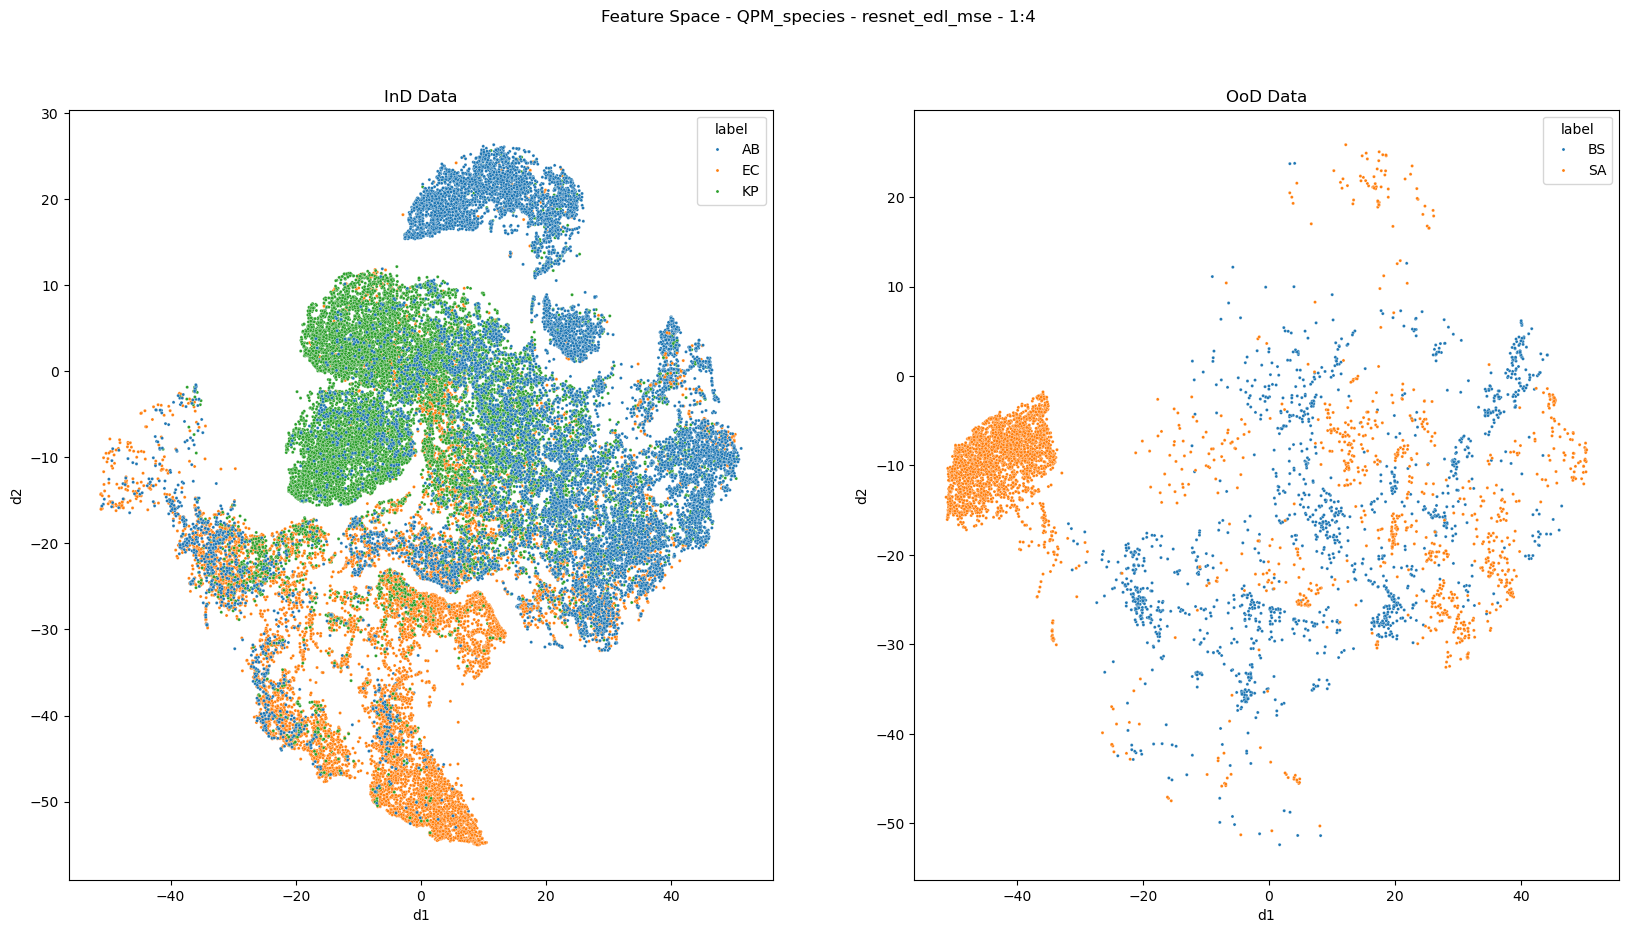

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

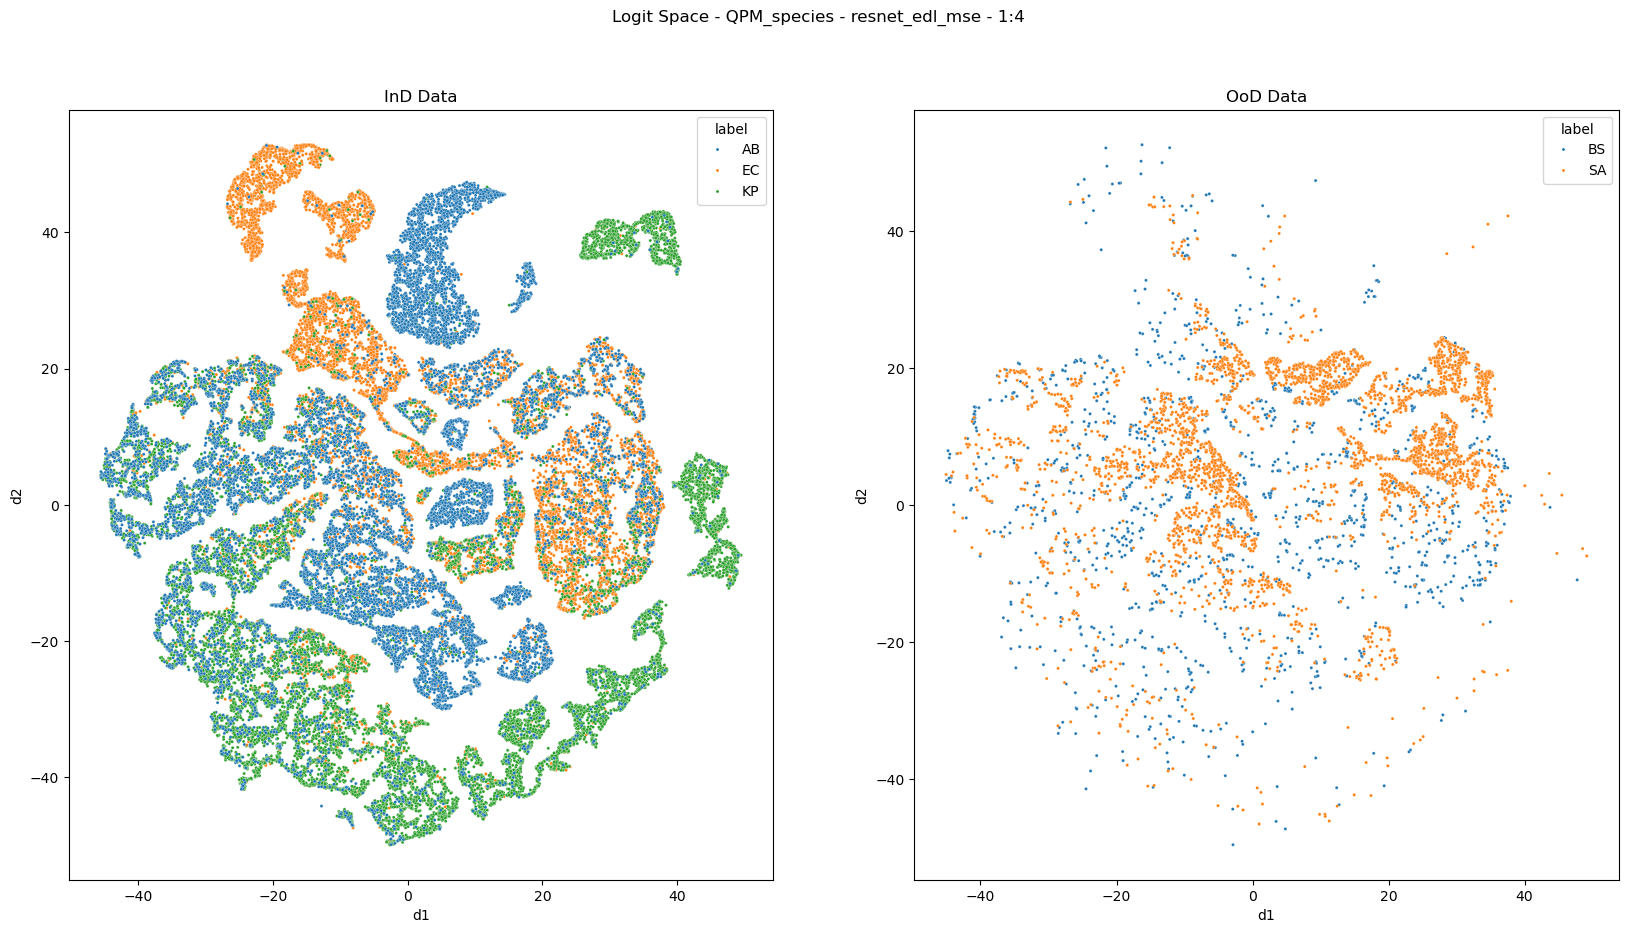

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:14<00:44, 14.88s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:29<00:29, 14.91s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:44<00:15, 15.00s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.19s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:00<00:00, 15.10s/it]

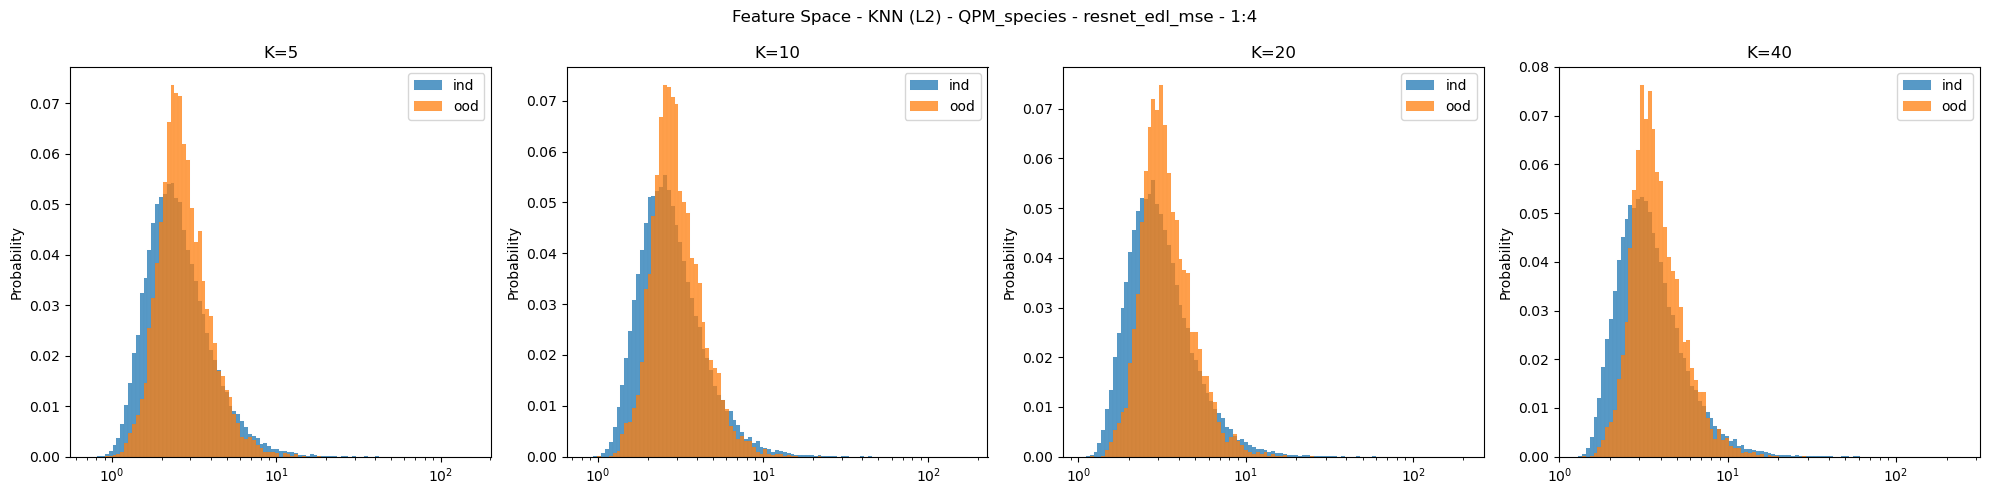

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:14<00:43, 14.55s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:29<00:29, 14.72s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:44<00:14, 14.75s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.90s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.83s/it]

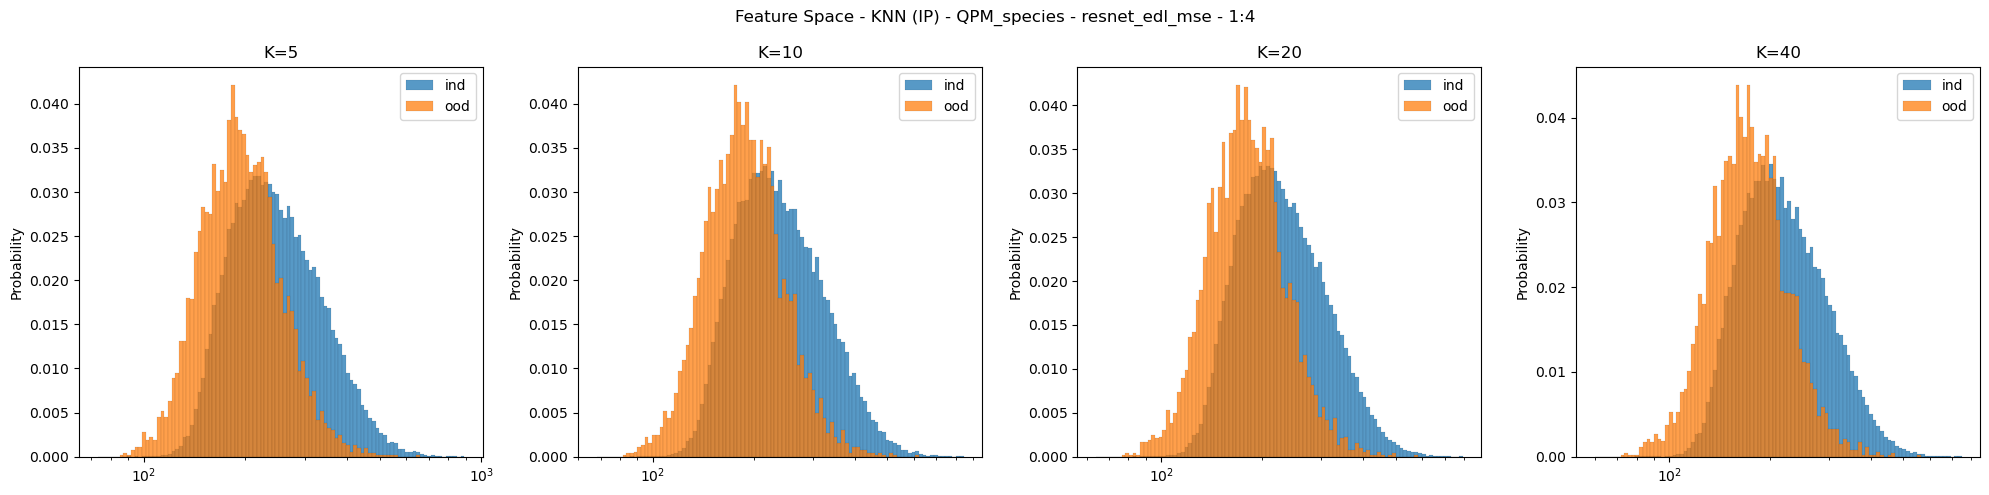

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:02<00:06,  2.07s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:04<00:04,  2.11s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:06<00:02,  2.20s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.37s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.28s/it]

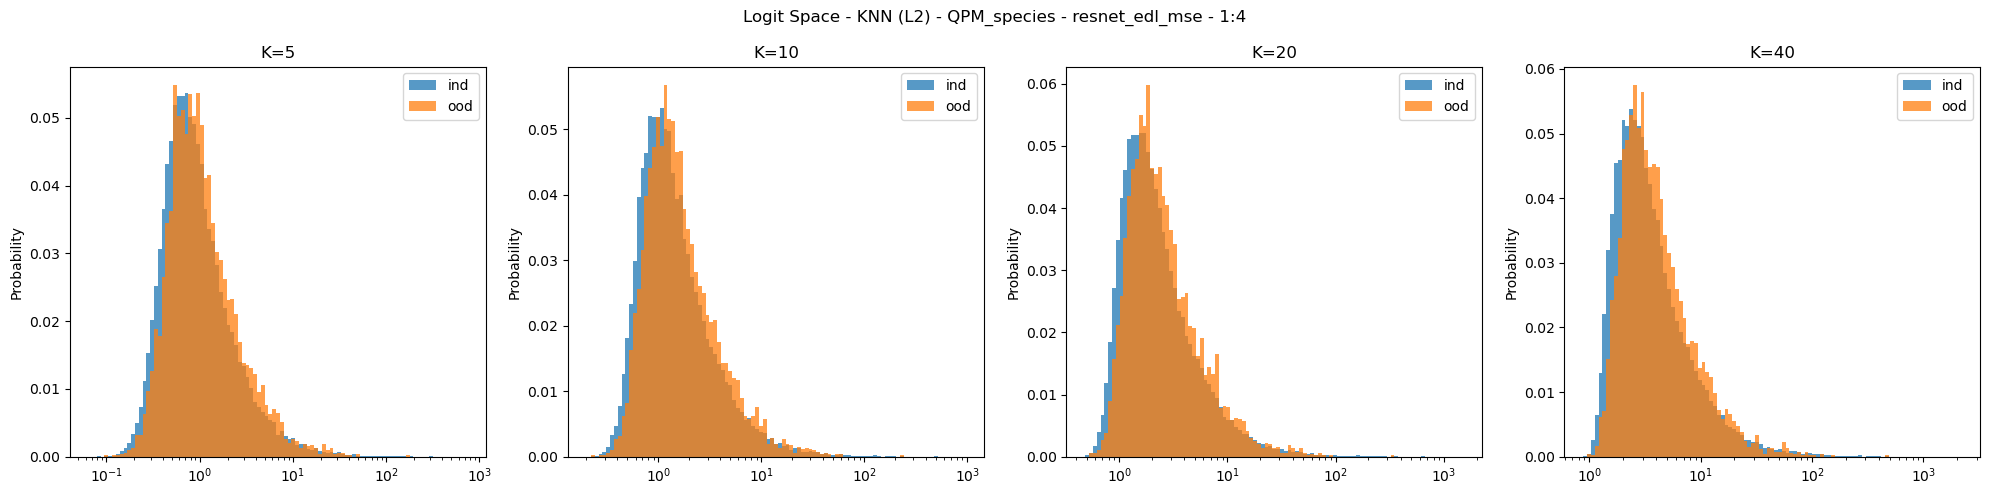

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:01<00:05,  1.79s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:03<00:03,  1.86s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:05<00:01,  1.95s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.04s/it]

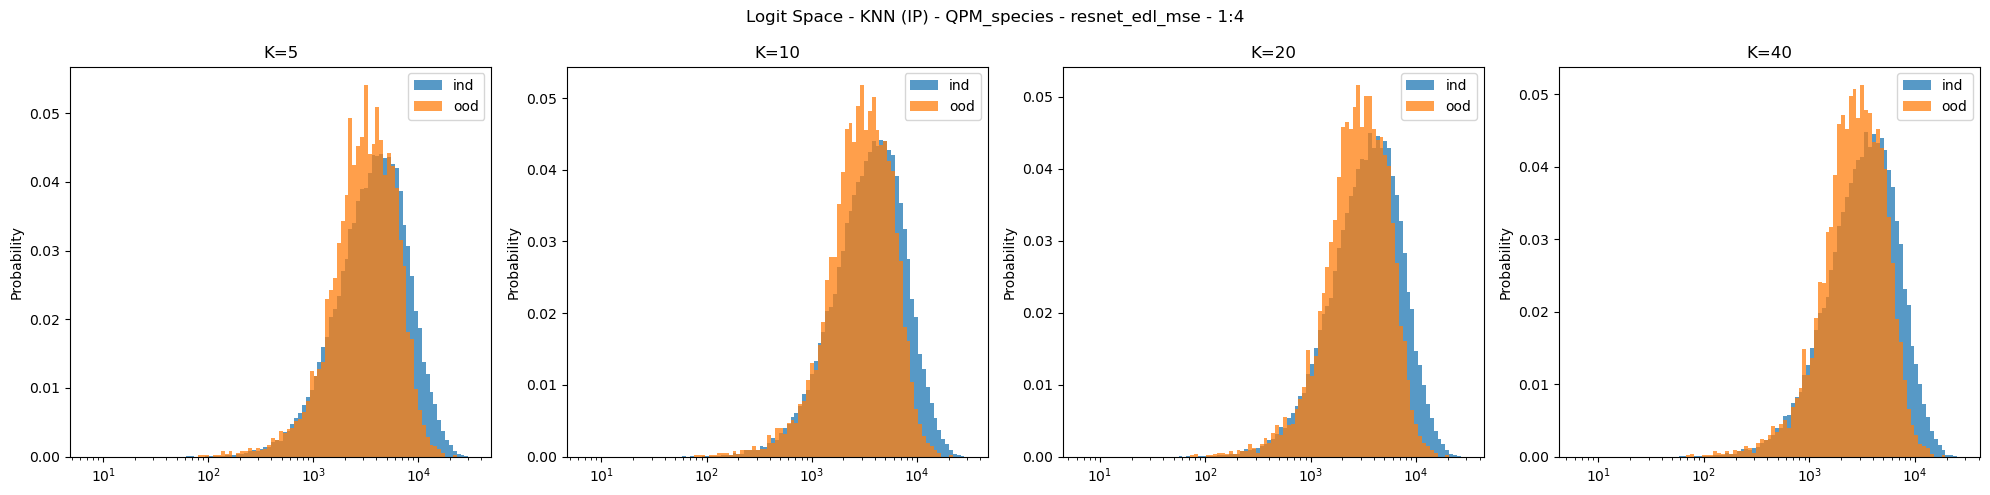

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_840231/3659132256.py:1: RuntimeWarning: overflow encountered in exp
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_840231/3659132256.py:1: RuntimeWarning: invalid value encountered in divide
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_840231/3659132256.py:6: RuntimeWarning: overflow encountered in exp
  ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_840231/3659132256.py:6: RuntimeWarning: invalid value encountered in divide
  ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)


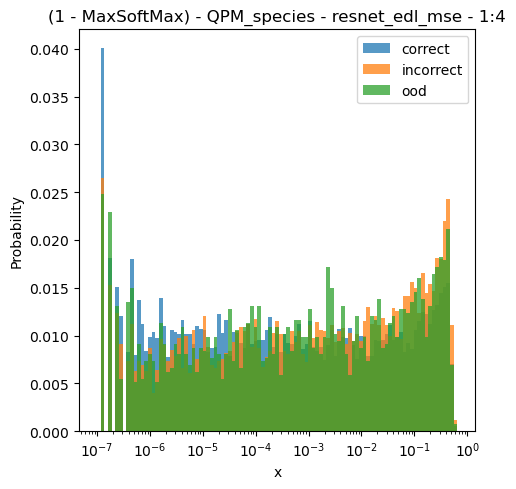

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

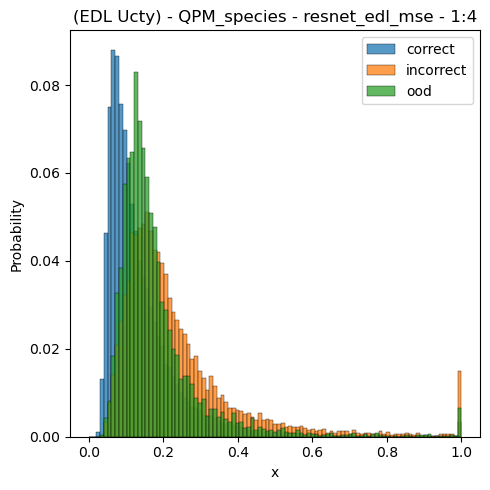

In [20]:
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

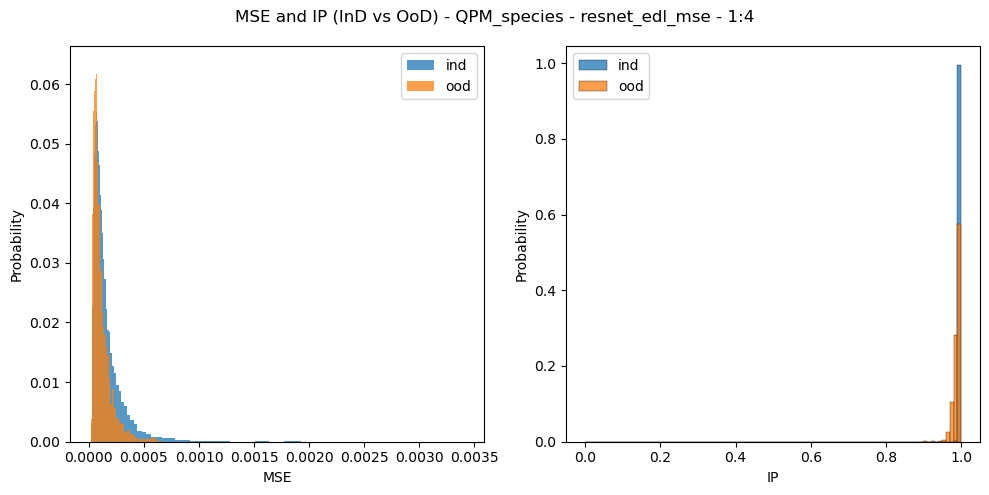

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()